# <center> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 6.  Vowpal Wabbit

На этой неделе мы познакомимся с популярной библиотекой Vowpal Wabbit и попробуем ее на данных соревнования. Знакомиться будем с помощью [данных](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html) Scikit-learn по новостям, сначала в режиме бинарной классификации, затем – в многоклассовом режиме. Далее будем классифицировать рецензии к фильмам с сайте IMDB. Наконец, применим Vowpal Wabbit к нашему соревнованию. Материала немало, но Vowpal Wabbit того стоит!

**План 6 недели:**
- Часть 1. Тьюториал по Vowpal Wabbit. Новости. Бинарная классификация
- Часть 2. Тьюториал по Vowpal Wabbit. Новости. Многоклассовая классификация
- Часть 3. Тьюториал по Vowpal Wabbit. Рецензии к фильмам IMDB
- Часть 4. Применение Vowpal Wabbit к данным по посещению сайтов


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Стохатический градиентный спуск](https://www.coursera.org/learn/supervised-learning/lecture/xRY50/stokhastichieskii-ghradiientnyi-spusk)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   
Также будет полезна [презентация](https://github.com/esokolov/ml-course-msu/blob/master/ML15/lecture-notes/Sem08_vw.pdf) лектора специализации Евгения Соколова. И, конечно же, [документация](https://github.com/JohnLangford/vowpal_wabbit/wiki) Vowpal Wabbit.

## Часть 1. Тьюториал по Vowpal Wabbit. Новости. Бинарная классификация

Vowpal Wabbit (VW) является одной из наиболее широко используемых библиотек в индустрии. Её отличает высокая скорость работы и поддержка большого количества различных режимов обучения. Особый интерес для больших и высокоразмерных данных представляет онлайн-обучение – самая сильная сторона библиотеки. 


Основным интерфейсом для работы с VW является shell.

In [1]:
import os
import re
import pandas as pd

import matplotlib.pyplot as plt
%pylab inline
import sklearn.datasets
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, make_scorer, log_loss
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import pickle

from vowpalwabbit.sklearn_vw import VWClassifier, VW
from collections import Counter
import itertools

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from scipy.sparse import csr_matrix, hstack

Для того, чтобы изучить возможные режимы работы vw, воспользуемся справкой:

In [2]:
!vw --help

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1


VW options:
  --random_seed arg                     seed random number generator
  --ring_size arg                       size of example ring

Update options:
  -l [ --learning_rate ] arg            Set learning rate
  --power_t arg                         t power value
  --decay_learning_rate arg             Set Decay factor for learning_rate 
                                        between passes
  --initial_t arg                       initial t value
  --feature_mask arg                    Use existing regressor to determine 
                                        which parameters may be updated.  If no
                                        initial_regressor given, also used for 
                                        initial weights.

Weight options:
  -i [ --initial_regressor ] arg        Initial regressor(s)
  --initial_weight arg                  Set all 

Vowpal Wabbit считывает данные из файла или стандартного ввода (stdin) в формате, который имеет следующий вид:

`[Label] [Importance] [Tag]|Namespace Features |Namespace Features ... |Namespace Features`

`Namespace=String[:Value]`

`Features=(String[:Value] )*`

где [] обозначает необязательные элементы, а (...)\* означает повтор неопределенное число раз. 

- **Label** является числом, "правильным" ответом. В случае классификации обычно принимает значение 1/-1, а в случае регрессии некоторое вещественное число
- **Importance** является числом и отвечает за вес примера при обучении. Это позволяет бороться с проблемой несбалансированных данных, изученной нами ранее
- **Tag** является некоторой строкой без пробелов и отвечает за некоторое "название" примера, которое сохраняется при предсказании ответа. Для того, чтобы отделить Tag от Importance лучше начинать Tag с символа '.
- **Namespace** служит для создания отдельных пространств признаков. В аргументах Namespace именуются по первой букве, это нужно учитывать при выборе их названий
- **Features** являются непосредственно признаками объекта внутри **Namespace**. Признаки по умолчанию имеют вес 1.0, но его можно переопределить, к примеру feature:0.1. 


К примеру, под такой формат подходит следующая строка:

```
1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park
```


чтобы убедиться в этом, запустим vw с этим обучающим примером:

In [3]:
! echo '1 1.0 |Subject WHAT car is this |Organization Maryland:0.5 College Park' | vw

For more information use: vw --help
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000   0.0000        8

finished run
number of examples per pass = 1
passes used = 1
weighted example sum = 1.000000
weighted label sum = 1.000000
average loss = 1.000000
best constant = 1.000000
best constant's loss = 0.000000
total feature number = 8


VW является прекрасным инструментом для работы с текстовыми данными. Убедимся в этом с помощью выборки 20newsgroups, содержащей письма из 20 различных тематических рассылок:

In [4]:
newsgroups = sklearn.datasets.fetch_20newsgroups('news_data/')

In [5]:
newsgroups['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Рассмотрим первый текстовый документ этой коллекции:

In [6]:
text = newsgroups['data'][0]
target = newsgroups['target_names'][newsgroups['target'][0]]

print('-----')
print(target)
print('-----')
print(text.strip())
print('----')

-----
rec.autos
-----
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
----


**Приведем данные к формату Vowpal Wabbit, при этом оставляя только слова не короче 3 символов. Здесь мы не выполняем многие важные в анализе текстов процедуры (стемминг и лемматизацию), но, как увидим, задача и так будет решаться хорошо.**

In [7]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', 
                                                              document.lower())) + '\n'

to_vw_format(text, 1 if target == 'rec.autos' else -1)

'1 |text from lerxst wam umd edu where thing subject what car this nntp posting host rac3 wam umd edu organization university maryland college park lines was wondering anyone out there could enlighten this car saw the other day was door sports car looked from the late 60s early 70s was called bricklin the doors were really small addition the front bumper was separate from the rest the body this all know anyone can tellme model name engine specs years production where this car made history whatever info you have this funky looking car please mail thanks brought you your neighborhood lerxst\n'

Разобьем выборку на обучающую и тестовую и запишем в файл преобразованные таким образом документы. Будем считать документ положительным, если он относится к рассылке про автомобили **rec.autos**. Так мы построим модель, отличающую письма про автомобили от остальных: 

In [8]:
all_documents = newsgroups['data']
all_targets = [1 if newsgroups['target_names'][target] == 'rec.autos' 
               else -1 for target in newsgroups['target']]

In [9]:
train_documents, test_documents, train_labels, test_labels = \
    train_test_split(all_documents, all_targets, random_state=7)
    
with open('news_data/20news_train.vw', 'w') as vw_train_data:
    for text, target in zip(train_documents, train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open('news_data/20news_test.vw', 'w') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

Запустим Vowpal Wabbit на сформированном файле. Мы решаем задачу классификации, поэтому зададим функцию потерь в значение hinge (линейный SVM). Построенную модель мы сохраним в соответствующий файл 20news_model.vw:

In [10]:
!vw -d news_data/20news_train.vw --loss_function hinge -f news_data/20news_model.vw

final_regressor = news_data/20news_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = news_data/20news_train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  -1.0000   0.0000      157
0.911276 0.822551            2            2.0  -1.0000  -0.1774      159
0.605793 0.300311            4            4.0  -1.0000  -0.3994       92
0.419594 0.233394            8            8.0  -1.0000  -0.8167      129
0.313998 0.208402           16           16.0  -1.0000  -0.6509      108
0.196014 0.078029           32           32.0  -1.0000  -1.0000      115
0.183158 0.170302           64           64.0  -1.0000  -0.7072      114
0.261046 0.338935          128          128.0   1.0000  -0.7900      110
0.262910 0.264774          256          256.0  -1.0000  -0.6425       44
0.216663

Модель обучена. VW выводит достаточно много полезной информации по ходу обучения. Обратите внимание, что average loss снижался по ходу выполнения итераций. Для вычисления функции потерь VW использует еще не просмотренные примеры, поэтому, как правило, эта оценка является корректной. Применим обученную модель на тестовой выборке, сохраняя предсказания в файл с помощью опции -p: 

In [11]:
!vw -i news_data/20news_model.vw -t -d news_data/20news_test.vw \
-p news_data/20news_test_predictions.txt

only testing
predictions = news_data/20news_test_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = news_data/20news_test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  unknown   1.0000      349
0.000000 0.000000            2            2.0  unknown  -1.0000       50
0.000000 0.000000            4            4.0  unknown  -1.0000      251
0.000000 0.000000            8            8.0  unknown  -1.0000      237
0.000000 0.000000           16           16.0  unknown  -0.8978      106
0.000000 0.000000           32           32.0  unknown  -1.0000      964
0.000000 0.000000           64           64.0  unknown  -1.0000      261
0.000000 0.000000          128          128.0  unknown   0.4621       82
0.000000 0.000000          256          256.0  unknown  -1.00

Загрузим полученные предсказания, вычислим AUC и отобразим ROC-кривую:

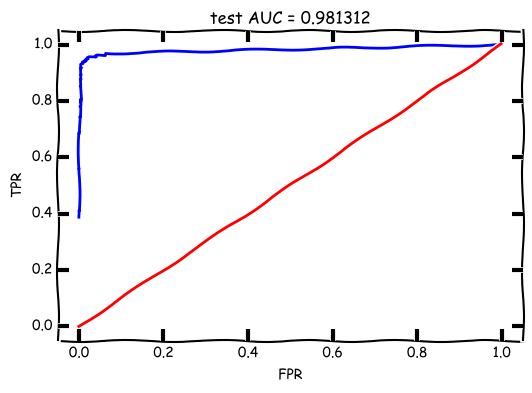

In [12]:
with open('news_data/20news_test_predictions.txt') as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]

auc = sklearn.metrics.roc_auc_score(test_labels, test_prediction)
roc_curve = sklearn.metrics.roc_curve(test_labels, test_prediction)

with plt.xkcd():
    plt.plot(roc_curve[0], roc_curve[1]);
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); plt.ylabel('TPR'); 
    plt.title('test AUC = %f' % (auc)); 
    plt.axis([-0.05,1.05,-0.05,1.05]);

Полученное значения AUC говорит о высоком качестве классификации.

## Часть 2. Тьюториал по Vowpal Wabbit. Новости. Многоклассовая классификация

**Используем ту же выборку, что в прошлой части, но решаем задачу многоклассовой классификации. Тут Vowpal Wabbit слегка капризничает – он любит, чтоб метки классов были распределены от 1 до K, где K – число классов в задаче классификации (в нашем случае – 20). Поэтому придется применить LabelEncoder, да еще и +1 потом добавить (LabelEncoder переводит метки в диапозон от 0 до K-1).**

In [13]:
all_documents = newsgroups['data']
topic_encoder = LabelEncoder()
all_targets_mult = topic_encoder.fit_transform(newsgroups['target']) + 1

**Выборки будут те же, а метки поменяются, train_labels_mult и test_labels_mult – векторы меток от 1 до 20.**

In [14]:
train_documents, test_documents, train_labels_mult, test_labels_mult = \
    train_test_split(all_documents, all_targets_mult, random_state=7)

In [15]:
with open('news_data/20news_train_mult.vw', 'w') as vw_train_data:
    for text, target in zip(train_documents, train_labels_mult):
        vw_train_data.write(to_vw_format(text, target))
with open('news_data/20news_test_mult.vw', 'w') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

**Обучим Vowpal Wabbit в режиме многоклассовой классификации, передав параметр *oaa* (от "one against all"), равный числу классов. Также перечислим параметры, которые можно понастраивать, и от которых качество модели может довольно значительно зависеть (более полно – в официальном [тьюториале](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial) по Vowpal Wabbit):**
 - темп обучения (-l, по умолчанию 0.5) – коэффициент перед изменением весов модели при каждом изменении
 - степень убывания темпа обучения (--power_t, по умолчанию 0.5) – на практике проверено, что если темп обучения уменьшается при увеличении числа итераций стохастического градиентного спуска, то минимум функции находится лучше 
 - функция потерь (--loss_function) – от нее, по сути, зависит обучаемый алгоритм
 - регуляризация (-l1) – тут надо обратить внимание на то, что в VW регуляризация считается для каждого объекта, поэтому коэффициенты регуляризации обычно берутся малыми, около $10^{-20}.$
 
 **Дополнительно: в соревновании можно попробовать автоматическую настройку параметров Vowpal Wabbit с Hyperopt. Пока это работает только с Python 2. [Статья](https://habrahabr.ru/company/dca/blog/272697/) на Хабре.**

In [16]:
%%time
!vw --oaa 20 news_data/20news_train_mult.vw -f news_data/20news_model_mult.vw \
--loss_function=hinge --quiet

CPU times: user 9.39 ms, sys: 15.2 ms, total: 24.6 ms
Wall time: 648 ms


In [17]:
%%time
!vw -i news_data/20news_model_mult.vw -t -d news_data/20news_test_mult.vw \
-p news_data/20news_test_predictions_mult.txt --quiet

CPU times: user 5.34 ms, sys: 13 ms, total: 18.4 ms
Wall time: 235 ms


In [18]:
with open('news_data/20news_test_predictions_mult.txt') as pred_file:
    test_prediction_mult = [float(label) 
                             for label in pred_file.readlines()]

In [19]:
accuracy_score(test_labels_mult, test_prediction_mult)

0.8734535171438671

**Выведем раскрашенную матрицу ошибок полученного классификатора. Если понаклонять монитор, можно заметить, какие ошибке чаще совершаются.**

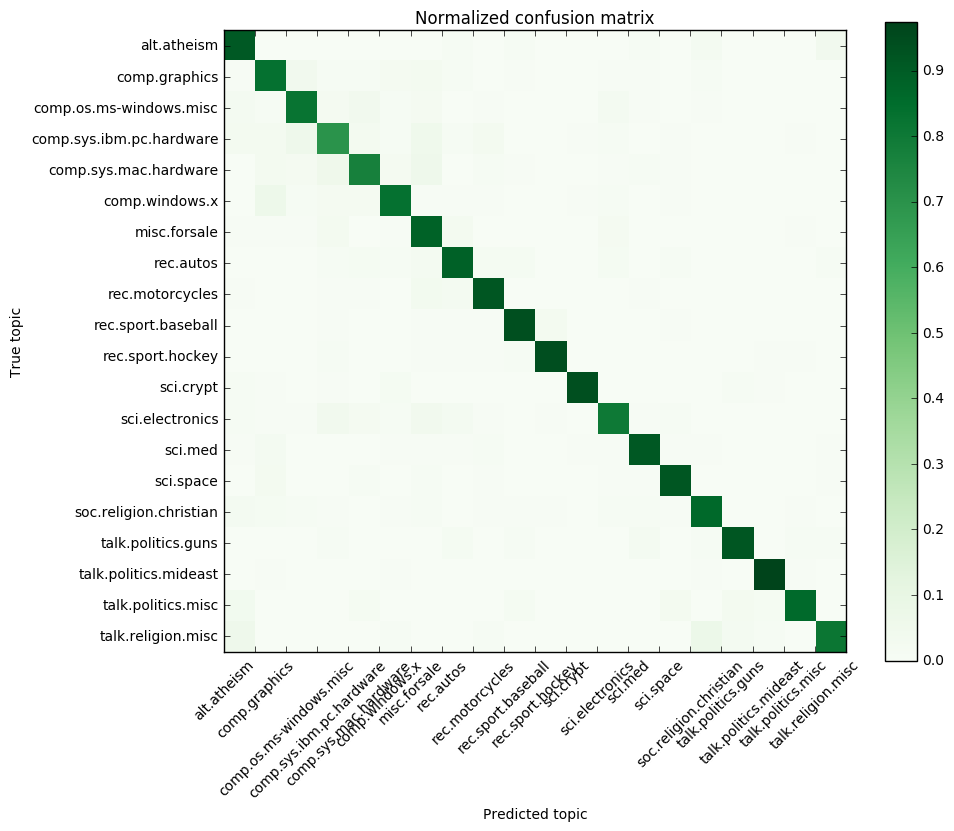

In [20]:
from sklearn.metrics import confusion_matrix

M = confusion_matrix(test_labels_mult, test_prediction_mult)
M_normalized = M.astype('float') / M.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,10))
im = plt.imshow(M_normalized, interpolation='nearest', cmap='Greens')
plt.colorbar(im, shrink=0.71)
tick_marks = np.arange(len(newsgroups['target_names']))
plt.xticks(tick_marks - 0.5, newsgroups['target_names'], rotation=45)
plt.yticks(tick_marks, newsgroups['target_names'])
plt.tight_layout()
plt.ylabel('True topic')
plt.xlabel('Predicted topic')
plt.title('Normalized confusion matrix')
plt.show()

## Часть 3. Тьюториал по Vowpal Wabbit. Рецензии к фильмам IMDB

**В этой части мы будем заниматься бинарной классификацией отзывов к фильмам, опубликованным на сайте IMDB. Обратите внимание, насколько быстро будет работать Vowpal Wabbit.**

**Используем функцию *load_files* из sklearn.datasets для загрузки отзывов по фильмам [отсюда](https://yadi.sk/d/Tg1Tflur333iLr). Скачайте данные и положите рядом с этой тетрадкой в каталог aclImdb (в нем должны быть каталоги *train* и *test*). Разархивирование может занять несколько минут – там 100 тыс. файлов. В обучающей и тестовой выборках по 12500 тысяч хороших и плохих отзывов к фильмам. Отделим данные (собственно тексты) от меток.**

In [21]:
from sklearn.datasets import load_files

In [22]:
reviews_train = load_files('aclImdb/train')
text_train, y_train = reviews_train.data, reviews_train.target

In [23]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


То же самое с тестовой выборкой.

In [24]:
reviews_test = load_files('aclImdb/test')
text_test, y_test = reviews_test.data, reviews_train.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


**Примеры отзывов и соответствующих меток.**

In [25]:
text_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

In [26]:
y_train[0] # хороший отзыв

1

In [27]:
text_train[1]

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [28]:
y_train[1] # плохой отзыв

0

**Будем использовать ранее написанную функцию to_vw_format.**

In [29]:
to_vw_format(str(text_train[1]), 1 if y_train[0] == 1 else -1)

'1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich xc3 xa9s mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regarding the airplane won list them here but just mention the coloring the plane they didn even manage show airliner the colors fictional airline but instead used 747 painted the original boeing livery very bad the plot stupid and has been done many times before only much much better there are many ridiculous moments here that lost count really early also was the bad guys side all the time the movie because the good guys were stupid executive decision should without doubt you choice over this one even the turbulence movies are better fact every other movie the world better than this one\n'

**Подготовим обучающую (movie_reviews_train.vw), отложенную (movie_reviews_valid.vw) и тестовую (movie_reviews_test.vw) выборки для Vowpal Wabbit. 70% исходной обучаюшей выборки оставим под обучение, 30% – под отложенную выборку.**

In [30]:
train_share = int(0.7 * len(text_train))
train, valid = text_train[:train_share], text_train[train_share:]
train_labels, valid_labels = y_train[:train_share], y_train[train_share:]

In [31]:
len(train_labels), len(valid_labels)

(17500, 7500)

In [32]:
with open('aclImdb/movie_reviews_train.vw', 'w') as vw_train_data:
    for text, target in zip(train, train_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with open('aclImdb/movie_reviews_valid.vw', 'w') as vw_train_data:
    for text, target in zip(valid, valid_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with open('aclImdb/movie_reviews_test.vw', 'w') as vw_test_data:
    for text in text_test:
        vw_test_data.write(to_vw_format(str(text)))

In [33]:
!head -2 aclImdb/movie_reviews_train.vw

1 |text zero day leads you think even think why two boys young men would what they did commit mutual suicide via slaughtering their classmates captures what must beyond bizarre mode being for two humans who have decided withdraw from common civility order define their own mutual world via coupled destruction not perfect movie but given what money time the filmmaker and actors had remarkable product terms explaining the motives and actions the two young suicide murderers better than elephant terms being film that gets under our rationalistic skin far far better film than almost anything you are likely see flawed but honest with terrible honesty
-1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich xc3 xa9s mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regardi

In [34]:
!head -2 aclImdb/movie_reviews_valid.vw

1 |text matter life and death what can you really say that would properly justice the genius and beauty this film powell and pressburger visual imagination knows bounds every frame filled with fantastically bold compositions the switches between the bold colours the real world the stark black and white heaven ingenious showing visually just how much more vibrant life the final court scene also fantastic the judge and jury descend the stairway heaven hold court over peter david niven operation all the performances are spot roger livesey being standout and the romantic energy the film beautiful never has there been more romantic film than this there has haven seen matter life and death all about the power love and just how important life and jack cardiff cinematography reason enough watch the film alone the way lights kim hunter face makes her all the more beautiful what genius can make simple things such game table tennis look exciting and the sound design also impeccable the way the so

In [35]:
!head -2 aclImdb/movie_reviews_test.vw

 |text don hate heather graham because she beautiful hate her because she fun watch this movie like the hip clothing and funky surroundings the actors this flick work well together casey affleck hysterical and heather graham literally lights the screen the minor characters goran visnjic sigh and patricia velazquez are talented they are gorgeous congratulations miramax director lisa krueger
 |text don know how this movie has received many positive comments one can call artistic and beautifully filmed but those things don make for the empty plot that was filled with sexual innuendos wish had not wasted time watch this movie rather than being biographical was poor excuse for promoting strange and lewd behavior was just another hollywood attempt convince that that kind life normal and from the very beginning asked self what was the point this movie and continued watching hoping that would change and was quite disappointed that continued the same vein glad did not spend the money see this t

**Обучим модель Vowpal Wabbit со следующими аргументами:**

 - -d, путь к обучающей выборке (соотв. файл .vw )
 - --loss_function – hinge (хотя можно и поэкспериментировать с другими)
 - -f – путь к файлу, в который запишется модель (можно тоже в формате .vw)

In [36]:
!vw -d aclImdb/movie_reviews_train.vw \
--loss_function hinge -f aclImdb/movie_reviews_model.vw --quiet

**Сделаем прогноз для отложенной выборки с помощью обученной модели Vowpal Wabbit, передав следующие аргументы:**
 - -i –путь к обученной модели (соотв. файл .vw)
 - -t -d – путь к отложенной выборке (соотв. файл .vw)
 - -p – путь к txt-файлу, куда запишутся прогнозы

In [37]:
!vw -i aclImdb/movie_reviews_model.vw -t -d aclImdb/movie_reviews_valid.vw \
-p aclImdb/movie_valid_pred.txt --quiet

**Считаем прогноз из файла и посчитаем долю правильных ответов и ROC AUC. Учтем, что VW выводит оценки вероятности принадлежности к классу +1. Эти оценки распределены на [-1, 1], поэтому бинарным ответом алгоритма (0 или 1) будем попросту считать тот факт, что оценка получилась положительной.**

In [38]:
with open('aclImdb/movie_valid_pred.txt') as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(valid_labels, 
               [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy: 0.885
AUC: 0.942


**Сделаем то же самое для тестовой выборки.**

In [39]:
!vw -i aclImdb/movie_reviews_model.vw -t -d aclImdb/movie_reviews_test.vw \
-p aclImdb/movie_test_pred.txt --quiet

In [40]:
with open('aclImdb/movie_test_pred.txt') as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(y_test, 
               [int(pred_prob > 0) for pred_prob in test_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction), 3)))

Accuracy: 0.88
AUC: 0.94


**Попробуем улучшить прогноз за счет задействования биграмм.**

In [41]:
!vw -d aclImdb/movie_reviews_train.vw \
--loss_function hinge --ngram 2 -f aclImdb/movie_reviews_model2.vw --quiet

In [42]:
!vw -i aclImdb/movie_reviews_model2.vw -t -d aclImdb/movie_reviews_valid.vw \
-p aclImdb/movie_valid_pred2.txt --quiet

In [43]:
with open('aclImdb/movie_valid_pred2.txt') as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(valid_labels, 
               [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy: 0.894
AUC: 0.954


In [44]:
!vw -i aclImdb/movie_reviews_model2.vw -t -d aclImdb/movie_reviews_test.vw \
-p aclImdb/movie_test_pred2.txt --quiet

In [45]:
with open('aclImdb/movie_test_pred2.txt') as pred_file:
    test_prediction2 = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(y_test, 
               [int(pred_prob > 0) for pred_prob in test_prediction2]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction2), 3)))

Accuracy: 0.888
AUC: 0.952


Видим, что биграммы помогли повысить качество классификации.

## Часть 4. Применение Vowpal Wabbit к данным по посещению сайтов

**Загрузим созданные ранее pickle-объекты, соответствующие разреженным данным [соревнования](https://inclass.kaggle.com/c/identify-me-if-you-can-yandex-mipt/data), которые мы создали на прошлой неделе.**

***Поправка: Заново получим разреженные матрицы***

In [209]:
from collections import Counter
def sparsematrix1(X):
    row = []
    col = []
    data = []
    for r in range(X.shape[0]):
        row_counter = Counter(X[r])
        for site, num in row_counter.items():
            row.append(r)
            col.append(site)
            data.append(num)
    print "columns:", len(set(col)), "rows:", X.shape[0]
    return csr_matrix((data, (row, col)), shape=(X.shape[0], len(set(col))))[:,1:]

In [205]:
train_df = pd.read_csv('kaggle_data/train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('kaggle_data/test_sessions.csv', index_col='session_id')

In [206]:
max_number = np.max(Counter(train_df.user_id).values())
user_counter = Counter(train_df.user_id)

In [207]:
%%time
train_data = pd.DataFrame(columns=train_df.columns)
for user, num in user_counter.items():
    rep = int(max_number / float(num))
    train_data = train_data.append([train_df[train_df.user_id == user]]*rep)
    #train_data = pd.concat([train_data, train_df[train_df.user_id == user]])

In [208]:
sorted(Counter(train_data.user_id).items(), key = lambda t:t[1])

[(537.0, 1927),
 (231.0, 2268),
 (106.0, 2496),
 (1273.0, 2673),
 (3370.0, 2684),
 (3375.0, 2769),
 (2855.0, 2870),
 (1845.0, 2904),
 (1957.0, 2910),
 (3328.0, 2920),
 (3333.0, 2976),
 (2773.0, 2984),
 (1076.0, 3030),
 (1657.0, 3033),
 (2971.0, 3036),
 (2366.0, 3036),
 (762.0, 3038),
 (3253.0, 3042),
 (1113.0, 3051),
 (1826.0, 3056),
 (1373.0, 3060),
 (638.0, 3064),
 (1807.0, 3065),
 (3324.0, 3068),
 (860.0, 3069),
 (1531.0, 3069),
 (2820.0, 3070),
 (1388.0, 3070),
 (1949.0, 3072),
 (54.0, 3080),
 (244.0, 3080),
 (1969.0, 3080),
 (2524.0, 3088),
 (2530.0, 3091),
 (754.0, 3096),
 (1760.0, 3102),
 (2991.0, 3105),
 (963.0, 3112),
 (1812.0, 3112),
 (1575.0, 3113),
 (2414.0, 3114),
 (2116.0, 3120),
 (2258.0, 3120),
 (285.0, 3120),
 (1840.0, 3130),
 (440.0, 3132),
 (940.0, 3132),
 (1817.0, 3133),
 (2266.0, 3144),
 (2861.0, 3144),
 (3302.0, 3146),
 (197.0, 3150),
 (3027.0, 3150),
 (3060.0, 3156),
 (1577.0, 3164),
 (286.0, 3168),
 (1550.0, 3168),
 (2004.0, 3168),
 (1737.0, 3170),
 (2903.0, 318

In [197]:
sorted(Counter(train_df.user_id).items(), key = lambda t:t[1])

[(2135, 25),
 (30, 25),
 (1070, 26),
 (2401, 27),
 (1863, 27),
 (55, 28),
 (2633, 28),
 (2986, 28),
 (3205, 28),
 (2653, 29),
 (2722, 29),
 (937, 29),
 (1745, 29),
 (2060, 30),
 (2877, 30),
 (1338, 30),
 (1005, 31),
 (6, 32),
 (155, 32),
 (2378, 32),
 (466, 32),
 (2650, 32),
 (2708, 32),
 (686, 32),
 (770, 32),
 (823, 32),
 (3174, 32),
 (1144, 32),
 (1686, 32),
 (2400, 33),
 (2784, 33),
 (3113, 33),
 (3130, 33),
 (1517, 33),
 (2305, 33),
 (2339, 34),
 (2690, 34),
 (702, 34),
 (774, 34),
 (936, 34),
 (1364, 34),
 (76, 35),
 (177, 35),
 (2517, 35),
 (791, 35),
 (3320, 35),
 (1614, 35),
 (1700, 35),
 (1793, 35),
 (1964, 35),
 (102, 36),
 (2171, 36),
 (353, 36),
 (2437, 36),
 (2445, 36),
 (3101, 36),
 (3108, 36),
 (2938, 37),
 (3049, 37),
 (2150, 37),
 (3257, 37),
 (2606, 37),
 (409, 38),
 (134, 38),
 (2321, 38),
 (1270, 38),
 (3378, 38),
 (1423, 38),
 (1829, 38),
 (224, 39),
 (336, 39),
 (2777, 39),
 (2605, 39),
 (1463, 39),
 (1681, 39),
 (44, 40),
 (2270, 40),
 (714, 40),
 (794, 40),
 (7

In [229]:
train_test_df = pd.concat([train_data, test_df])

train_test_df_sites = train_test_df[['site1', 'site2', 'site3', 
                                     'site4','site5', 
                                     'site6','site7', 'site8', 
                                     'site9', 'site10']].fillna(0).astype('int')
X_train_test_sparse = sparsematrix1(train_test_df_sites.as_matrix())
X_train_sparse = X_train_test_sparse[:len(train_data)]
X_test_sparse = X_train_test_sparse[len(train_data):]
y = train_data["user_id"]
#y = train_df["target"]

columns: 24053 rows: 1839885


*** Закончили поправку, подгружать из pickle не будем ***

In [134]:
import pickle
from scipy.sparse import vstack
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from datetime import datetime

In [47]:
with open('kaggle_data/X_train_sparse.pkl', 'rb') as X_train_sparse_pkl:
    X_train_sparse = pickle.load(X_train_sparse_pkl)
with open('kaggle_data/X_test_sparse.pkl', 'rb') as X_test_sparse_pkl:
    X_test_sparse = pickle.load(X_test_sparse_pkl)
with open('kaggle_data/train_target.pkl', 'rb') as train_target_pkl:
    y = pickle.load(train_target_pkl)

### Trying TF-IDF and extra features

In [219]:
X_train_sparse.shape[0], X_test_sparse.shape[0], X_train_sparse.shape[0] + X_test_sparse.shape[0], X_test_sparse.shape[1]

(95319, 1744566, 1839885, 24052)

In [213]:
X = vstack([X_train_sparse, X_test_sparse])
X.shape[0]

1839885

In [214]:
X_strings = []
for r in range(X.shape[0]):
    X_strings.append(" ".join(X.getrow(r).nonzero()[1].astype(str)))

KeyboardInterrupt: 

In [110]:
tfidf = TfidfVectorizer(analyzer=str.split, max_df=1.0, ngram_range=(1,3)).fit(X_strings) #TfidfVectorizer()
X_train_test_sparse = tfidf.transform(X_strings)

In [113]:
X_train_sparse = X_train_test_sparse[:X_train_sparse.shape[0]]
X_test_sparse = X_train_test_sparse[X_train_sparse.shape[0]:]

In [159]:
parse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
for df in [train_df, test_df]:
    df["time1format"] = df.time1.apply(parse)
    df["weekday"] = df["time1format"].apply(lambda x: int(x.isoweekday()))
    df["starthour"] = df["time1format"].apply(lambda x: int(x.hour))

In [173]:
csr_matrix(train_df[["weekday", "starthour"]], dtype=float)

<95319x2 sparse matrix of type '<type 'numpy.float64'>'
	with 190638 stored elements in Compressed Sparse Row format>

In [176]:
X_train_sparse_datetime = hstack([X_train_sparse, csr_matrix(train_df[["weekday", "starthour"]], dtype=int)], dtype=float)
X_test_sparse_datetime = hstack([X_test_sparse, csr_matrix(test_df[["weekday", "starthour"]], dtype=int)], dtype=float)

In [181]:
X_train_sparse_datetime

<95319x24054 sparse matrix of type '<type 'numpy.float64'>'
	with 728481 stored elements in COOrdinate format>

In [169]:
datetime_vw_train = []
for r, val in train_df[["starthour", "weekday"]].iterrows():
    datetime_vw_train.append(" |c_starthour {} |b_weekday {}".format(val.starthour, val.weekday))
    
datetime_vw_test = []
for r, val in test_df[["starthour", "weekday"]].iterrows():
    datetime_vw_test.append( "|c_starthour {} |b_weekday {}".format(val.starthour, val.weekday))

## end of trying

**Vowpal Wabbit любит, чтоб метки классов были распределены от 1 до K, где K – число классов в задаче классификации (в нашем случае – 550). Поэтому придется применить LabelEncoder, да еще и +1 потом добавить (LabelEncoder переводит метки в диапозон от 0 до K-1).**

In [230]:
class_encoder = LabelEncoder().fit(y.astype('str'))
y_for_vw = class_encoder.transform(y.astype('str')) + 1

In [231]:
len(unique(y_for_vw))

550

In [232]:
X_train_sparse

<1798708x24052 sparse matrix of type '<type 'numpy.int64'>'
	with 10033538 stored elements in Compressed Sparse Row format>

**Выделим обучающую и оставленную части исходной обучающей выборки.**

In [233]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y_for_vw, test_size=0.3, 
                                                     random_state=7, stratify=y_for_vw)

In [185]:
X_train[:,-1]

<66723x1 sparse matrix of type '<type 'numpy.float64'>'
	with 66723 stored elements in Compressed Sparse Row format>

**Реализуйте функцию, переводящую разреженную матрицу в формат Vowpal Wabbit.**

Вход:
 - X_sparse – разреженная матрица SciPy.sparse.csr_matrix
 - y (необяз.) – вектор ответов. Необязателен, поскольку тестовую матрицу будем обрабатывать этой же функцией
 - out_file – путь к файлу .vw, в который будет произведена запись
 
Детали:
- можно делать по-разному, но скорее всего помогут атрибуты *data* и *indices* разреженной матрицы. Обратите внимание на особенность (или баг?) csr_matrix: если признак 8 попадается 3 раза, ему в паре *data* и *indices* могут быть соответвствовать как [3] в *data* и [8] в *indices*, так и [1,1,1] в *data* и [8,8,8] в *indices*.
- в тестовой выборке на месте меток целевого класса можно писать произвольные, допустим, 1

In [234]:
from vowpalwabbit.sklearn_vw import tovw

def sparse_matrix_to_vw1(X_sparse, y=None, out_file='tmp.vw'):
    thelist = tovw(X_sparse, y)
    thefile = open(out_file, 'w')
    for item in thelist:
        thefile.write("%s\n" % item)

In [155]:
def sparse_matrix_to_vw(X_sparse, y=None, out_file='tmp.vw'):
    sessions = {}
    used = {}
    print "Preparing file", out_file
    for r, c in zip(X_sparse.nonzero()[0], X_sparse.nonzero()[1]):
        if tuple([r,c]) not in used:
            used[tuple([r, c])] = 1
            if r in sessions:
                #sessions[r] += " {}:{}".format(c+1, X_sparse[r,c])
                sessions[r][c+1] = int(X_sparse[r,c])
            else:
                #if y is not None:
                    #sessions[r] = str(y[r] or '1') + ' |site' + " {}:{}".format(c+1, X_sparse[r,c])
                #else:
                    #sessions[r] = '1 |site' + " {}:{}".format(c+1, X_sparse[r,c])
                sessions[r] = {c+1: int(X_sparse[r,c])}
            
    with open(out_file, 'w') as vw_writer:
        for num, ses in sorted(sessions.items(), key=lambda t: t[0], reverse=False):
            if y is not None:
                line = str(y[num]) + ' |site'
            else:
                line = ' |site'
            for sindex, val in sorted(ses.items()):
                line += " {}:{}".format(sindex, val)
            vw_writer.write(line + "\n")

**Примените написанную функцию к части обучающей выборки (X_train, y_train), к отложенной выборке (X_valid, y_valid), ко всей обучающей выборке (X_train_sparse, y_for_vw) и ко всей тестовой выборке X_test_sparse.**

In [235]:
%%time
sparse_matrix_to_vw1(X_train, y_train, 'kaggle_data/train_part1.vw')
sparse_matrix_to_vw1(X_valid, y_valid, 'kaggle_data/valid1.vw')
sparse_matrix_to_vw1(X_train_sparse, y_for_vw, 'kaggle_data/train1.vw')
sparse_matrix_to_vw1(X_test_sparse, out_file='kaggle_data/test1.vw')

CPU times: user 1min 34s, sys: 1.9 s, total: 1min 36s
Wall time: 1min 35s


**Первые 3 строки из каждого файла должны получиться примерно такими (с точностью до нумерации сайтов). **

In [189]:
X_train[0,-2]

3.0

In [192]:
!head -5 kaggle_data/train_part1.vw

214 1 | 0:0.1053233698355966 2002:0.6154323173582925 2113:0.2343422697356607 7336:0.3824294213741713 8446:0.1491816272717905 15785:0.3930877131374314 16512:0.3716665421683645 21386:0.3067121812018033 24052:3 24053:12
20 1 | 1:0.2089839451945613 447:0.2966621381058127 558:0.2733505457211943 3335:0.2049326462054885 8446:0.7647394752702761 11112:0.2648829780758198 17720:0.1733589571387436 20608:0.2579856410875234 24052:6 24053:15
367 1 | 0:0.06743845732211741 1891:0.1126763974292838 2514:0.1544040770006559 5360:0.3105947978071486 6665:0.6090705784875947 11945:0.6211895956142972 11946:0.3184068630506993 17720:0.06496093287991533 24052:5 24053:14
406 1 | 0:0.1262927798007264 1891:0.2110103939849269 3335:0.143809643807663 5191:0.8173808884920062 16499:0.2521581813735415 17276:0.2553596199872844 17720:0.1216530910940969 19164:0.2726996521530635 20608:0.1810391064539657 24052:5 24053:13
322 1 | 0:0.7040185195885083 1225:0.4675739698166606 3335:0.2004165493383162 12891:0.258721470643653 17720:0

In [6]:
!head -3 kaggle_data/train_part.vw

214 | sites 472:1 485:1 8:1 487:1 444:2 387:1 251:1 67:2
20 | sites 38:1 55:1 251:3 32:1 82:1 9:1 27:1 11:1
367 | sites 15780:1 65:1 443:1 15779:2 15794:1 8:1 15773:2 32:1


In [7]:
!head -3 kaggle_data/valid.vw

349 | sites 77:1 8:1 429:1 15413:1 38:2 515:2 3804:1 65:1
294 | sites 1945:1 280:1 1940:8
97 | sites 8:1 245:1 38:2 239:1 55:1 237:4


In [8]:
!head -3 kaggle_data/train.vw

150 | sites 8:3 932:1 3260:1 11:1 8393:1 68:1 8403:1 82:1
415 | sites 111:2 1401:2 151:2 78:1 38:1 1375:1 97:1
178 | sites 3187:2 3184:1 11:1 504:1 3191:1 132:1 82:1 1969:1 496:1


In [86]:
!head -3 kaggle_data/test.vw

 |site 1917:1
 |site 9:1 27:1 32:1 20225:5 20258:1 20276:1
 |site 22:1 63:2 64:2 70:1 71:4


**Обучите модель на выборке kaggle_data/train_part.vw. Укажите, что решается задача классификации с 550 классами (--oaa), сделайте 10 проходов по выборке (--passes). Задайте некоторый кэш-файл (--cache_file), так VW будет быстрее делать все следующие после первого проходы по выборке. Также укажите значение параметра b=26. Это число бит, используемых для хэширования, в данном случае нужно больше, чем 18 по умолчанию. Остальные параметры пока не меняйте, далее уже в свободном режиме соревнования можете попробовать другие функции потерь.**

In [236]:
model = VW(oaa=550, passes=5, b=26, quiet=False, convert_to_vw=True)

model.fit(X_train, y_train)
print accuracy_score(model.predict(X_valid), y_valid)

0.567045271333


In [183]:
trainvw = open("kaggle_data/train.vw").readlines()
np.random.shuffle(trainvw)
with open("kaggle_data/train.vw", "wb") as f:
    for item in trainvw:
        f.write("%s" % item)

In [184]:
%%time
!vw --oaa=550 -d kaggle_data/train_part.vw --passes=10 \
-f kaggle_data/initial_model.vw -b 26 --random_seed=7 -c

final_regressor = kaggle_data/initial_model.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = kaggle_data/train.vw.cache
Reading datafile = kaggle_data/train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      534        1        3
1.000000 1.000000            2            2.0      276      534        3
1.000000 1.000000            4            4.0      243      534       10
1.000000 1.000000            8            8.0      434      534        9
1.000000 1.000000           16           16.0      134      534        4
1.000000 1.000000           32           32.0      106      276        7
0.984375 0.968750           64           64.0      196      434       11
0.976562 0.968750          128          128.0      416      223        7
0.929688 0.882812        

**Запишите прогнозы на выборке *kaggle_data/valid.vw* в *kaggle_data/vw_valid_pred.csv*. Укажите random seed = 7.**

In [186]:
%%time
!vw -i kaggle_data/initial_model.vw -t -d kaggle_data/valid.vw \
-p kaggle_data/vw_valid_pred.csv --random_seed=7

only testing
predictions = kaggle_data/vw_valid_pred.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = kaggle_data/valid.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       54      487        2
1.000000 1.000000            2            2.0      231      214        6
1.000000 1.000000            4            4.0      142      141        9
0.750000 0.500000            8            8.0      179      179        7
0.750000 0.750000           16           16.0      423      440        5
0.562500 0.375000           32           32.0      328      328        8
0.437500 0.312500           64           64.0      227      227        8
0.468750 0.500000          128          128.0      159      471        4
0.476562 0.484375          256          256.0      184      184        9


**Считайте прогнозы *kaggle_data/vw_valid_pred.csv*  из файла и посмотрите на долю правильных ответов на отложенной части.**

In [187]:
vw_valid_pred = pd.read_csv("kaggle_data/vw_valid_pred.csv", header=None)
accuracy_score(y_valid, vw_valid_pred.values)

0.55349824355971899

**Какой получается доля правильных ответов на отложенной выборке? Запишите в файл *answer6_1.txt*, округлив до 3 знаков после запятой.**

In [23]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

In [24]:
write_answer_to_file(round(accuracy_score(y_valid, vw_valid_pred.values), 3),
                     'answer6_1.txt')

**Обучите модель с теми же параметрами на всей обучающей выборке – *kaggle_data/train.vw*. При этом укажите новый кэш-файл (--cache_file).**

In [115]:
%%time
!vw --oaa=550 -d kaggle_data/train.vw --passes=10 \
-f kaggle_data/initial_model.vw -b 26 --random_seed=7 -c -k

final_regressor = kaggle_data/initial_model.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = kaggle_data/train.vw.cache
Reading datafile = kaggle_data/train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      150        1        9
1.000000 1.000000            2            2.0      415      150        8
1.000000 1.000000            4            4.0       64      415        9
1.000000 1.000000            8            8.0      492      150        8
1.000000 1.000000           16           16.0      276      415        8
1.000000 1.000000           32           32.0      159      384        7
0.984375 0.968750           64           64.0       66      150        6
0.968750 0.953125          128          128.0       35      469        7
0.886719 0.804688        

**Сделайте прогноз для тестовой выборки.**

In [116]:
%%time
!vw -i kaggle_data/initial_model.vw -t -d kaggle_data/valid.vw \
-p kaggle_data/vw_test_pred.csv --random_seed=7

only testing
predictions = kaggle_data/vw_test_pred.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = kaggle_data/valid.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0      349      349        9
0.500000 1.000000            2            2.0      294       18        4
0.500000 0.500000            4            4.0      420      420        8
0.500000 0.500000            8            8.0      530      530       10
0.312500 0.125000           16           16.0      190      190        4
0.312500 0.312500           32           32.0      299      425        3
0.375000 0.437500           64           64.0      176      425        3
0.382812 0.390625          128          128.0      487      258        8
0.406250 0.429688          256          256.0      214      214        3
0

**Запишите прогноз в файл, примените обратное преобразование меток (был LabelEncoder и потом +1 в меткам) и отправьте решение на Kaggle.**

In [55]:
def write_to_submission_file(predicted_labels, out_file,
                             target='user_id', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

Прогноз, считанный из файла:

In [117]:
vw_pred = pd.read_csv("kaggle_data/vw_test_pred.csv", header=None)

Прогноз для отправки на Kaggle:

In [118]:
vw_subm = class_encoder.inverse_transform(vw_pred-1)

In [119]:
vw_valid_pred = pd.read_csv("kaggle_data/vw_test_pred.csv", header=None)
accuracy_score(y_valid, vw_valid_pred.values)

0.51234438382990632

In [120]:
vw_subm

array([['2956'],
       ['1076'],
       ['53'],
       ..., 
       ['1962'],
       ['189'],
       ['3375']], dtype=object)

In [56]:
write_to_submission_file(vw_subm,
                         'kaggle_data/first_vw_submission.csv')

**Полученный результат соответсвует бейзлайну "1st Vowpal Wabbit" на публичном лидерборде в нашем соревновании Kaggle.**

## Напутствие

Итак, мы познакомились с отличной библиотекой Vowpal Wabbit. Хотя это только начало: в VW реализованы матричные разложение и обучение с подкреплением, тематическое моделирование и активное обучение, name entity recognition и нейронные сети. Если Вам придется как-нибудь обучать модель на терабайте данных, при этом расходуя несколько мегабайт оперативной памяти, Вы наверняка вернетесь к этому тьюториалу (если, конечно, не выпустят библиотеку с более удобным интерфейсом). Хочется верить, что именно эта часть проекта оказалось самой полезной!

## Пути улучшения
На этой неделе опять дается время на соревнование, а также на оформление финального проекта.
Что еще можно попробовать:
 - Использовать ранее построенные признаки для улучшения модели
 - Настроить параметры Vowpal Wabbit с hyperopt, попробовать другие функции потерь
 - Попробовать TF-IDF и n-граммы

На следующей, заключительной, неделе мы оформим всю работу над проектом в виде одного файла (.pdf или .ipynb) и будем проверять проекты друг друга.

**Научимся подгружать дополнительные признаки для работы с Vowpal Wabbit.**

In [3]:
train_data = pd.read_csv('kaggle_data/full_train.csv')

test_data = pd.read_csv('kaggle_data/full_test.csv')

#y = train_data["target"]

#class_encoder = LabelEncoder().fit(y.astype('str'))
#y_for_vw = class_encoder.transform(y.astype('str')) + 1

In [19]:
test_data.shape

(27327, 41)

In [17]:
test_data = pd.DataFrame(test_data.iloc[:-1])

In [20]:
train_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)

In [54]:
train_index_full = list(train_data.index)
train_index_dup = list(train_data[train_data.duplicated(subset=['site' + str(c) for c in range(1,10+1)], keep=False)]\
                       [['site' + str(c) for c in range(1,10+1)]+["target"]].index)

test_index_full = list(test_data.index)
test_index_dup = list(test_data[test_data.duplicated(subset=['site' + str(c) for c in range(1,10+1)], keep=False)]\
                       [['site' + str(c) for c in range(1,10+1)]].index)

In [22]:
len(train_index_dup), len(test_index_dup)

(3259, 992)

In [55]:
train_user_dup_rows_dict = {}
train_dup_row_users_dict = {}
train_row_users = {}

test_dup_rows_dict = {}
test_row_users = {}

sites_cols = ['site' + str(c) for c in range(1,10+1)]

for r, row in train_data.iloc[train_index_dup][sites_cols+["target"]].iterrows():
    if row["target"] in train_user_dup_rows_dict:
        if tuple(row[sites_cols]) in train_user_dup_rows_dict[row["target"]]:
            train_user_dup_rows_dict[row["target"]][tuple(row[sites_cols])] += 1
        else:
            train_user_dup_rows_dict[row["target"]][tuple(row[sites_cols])] = 1 
    else:
        train_user_dup_rows_dict[row["target"]] = {tuple(row[sites_cols]): 1}
    
    if r in train_row_users:
        train_row_users[r].append(row["target"])
    else:
        train_row_users[r] = [row["target"]]

    if tuple(row[sites_cols]) in train_dup_row_users_dict:
        train_dup_row_users_dict[tuple(row[sites_cols])].append(row["target"])
    else:
        train_dup_row_users_dict[tuple(row[sites_cols])] = [row["target"]]
        
for r, row in test_data.iloc[test_index_dup][sites_cols].iterrows():  
    if tuple(row[sites_cols]) in test_dup_rows_dict:
        test_dup_rows_dict[tuple(row[sites_cols])] += 1
    else:
        test_dup_rows_dict[tuple(row[sites_cols])] = 1
    
    if tuple(row[sites_cols]) in train_dup_row_users_dict:
        if r in test_row_users:
            test_row_users[r] += train_dup_row_users_dict[tuple(row[sites_cols])]
        else:
            test_row_users[r] = train_dup_row_users_dict[tuple(row[sites_cols])]

In [24]:
len(test_row_users), len(test_data[test_data.prediction > 0])

(742, 5513)

In [56]:
for r, v in test_data[["prediction"]].iterrows():
    if int(v) != 0:
        test_row_users[r] = [int(v)]

In [26]:
len(test_row_users), len(test_data[test_data.prediction > 0])

(6255, 5513)

In [57]:
site_pairs = {}
for r, row in train_data[sites_cols+["target"]].iterrows():
    unique_sites = Counter(row).keys()
    if 0 in unique_sites:
        del unique_sites[unique_sites.index(0)]
    if len(unique_sites) > 1:
        for subset in itertools.permutations(Counter(row).keys(), 2):
            if tuple(subset) in site_pairs:
                site_pairs[tuple(subset)].add(row["target"])
            else:
                site_pairs[tuple(subset)] = set([row["target"]])
    #if len(unique_sites) > 2:
        #for subset in itertools.permutations(Counter(row).keys(), 3):
            #if tuple(subset) in site_pairs:
                #site_pairs[tuple(subset)].add(row["target"])
            #else:
                #site_pairs[tuple(subset)] = set([row["target"]])

In [28]:
len(test_row_users), len(test_data)

(6255, 27327)

In [58]:
for r, row in test_data[sites_cols].iterrows():
    unique_sites = Counter(row).keys()
    if len(unique_sites) > 1:
        for subset in itertools.permutations(Counter(row).keys(), 2):
            if subset in site_pairs:
                if r in test_row_users:
                    pass
                else:
                    test_row_users[r] = list(site_pairs[subset])

In [85]:
test_row_users

{0: array([126, 461, 327, 487, 328, 491, 167, 110, 337, 168, 166, 179,  76,
        330, 506, 386, 392, 230, 314, 289, 128,  25,  23, 340, 407, 317,
        471,  17,  24, 249, 367, 439]),
 1: array([517]),
 2: array([ 90, 117, 463, 372, 186, 187,  13, 374, 279, 473,  16, 382, 478,
        189, 383, 515,  23, 533, 106, 192, 107, 296, 465, 390,  15, 108,
        394, 111,  29,  30, 112, 176, 401, 202,  35, 493, 122, 208, 151,
        121, 545, 212, 127, 502, 487, 219, 413, 415,  51, 418,  14, 318,
        422, 516, 442, 141, 227, 145, 229, 426, 235,  62, 153, 239, 240,
        430, 529, 242, 338, 436, 342, 441, 344, 345, 162, 443, 535, 349,
        165, 354, 541, 171, 237, 452, 356,  49, 220, 549,  81, 267, 269,
         85,   2, 271, 365,  88, 155]),
 3: array([168, 138, 224, 317]),
 4: array([486]),
 5: array([283,  31, 534, 545, 346, 423, 518, 320, 258,  35, 203, 372, 325,
        147, 326,  98, 425,  56, 354,  38, 427,  18, 404, 173, 379, 232,
        477, 500, 176, 172, 211, 124, 4

In [30]:
len(test_row_users), len(test_data)

(27243, 27327)

In [31]:
len([[k, v] for k, v in test_row_users.items() if len(v) ==1 ])

6975

In [4]:
def calc_site_times_portions(train_data, test_data):
    site_times = [{},{}]
    count = 0
    for data in [train_data, test_data]:
        for r, row in data[:][range(0, 10)+range(20,30)].iterrows():
            rowdic = {}
            for c, s in [[c, 'site' + str(c)] for c in range(1,10)]:
                if row[s] == 0:
                    continue
                if row[s] in rowdic:
                    rowdic[int(row[s])] += row["time_diff"+str(c)]
                else:
                    rowdic[int(row[s])] = row["time_diff"+str(c)]
            site_times[count][r] = {}
            for site, time in rowdic.items():
                if len(rowdic) == 1:
                    site_times[count][r][int(site)] = 1.0
                    continue
                if time > 0:
                    site_times[count][r][int(site)] = round(float(time)/row["session_timespan"],3)
        count+=1
    return site_times

In [5]:
def site_times_to_sparse(sitetimes):
    row = []
    col = []
    data = []
    rowcount = 0
    for sitetime in sitetimes:
        for r, sites in sitetime.items():
            for site, p in sites.items():
                col.append(site)
                row.append(rowcount)
                data.append(p)
            rowcount+=1
    site_times_sparse = csr_matrix((data, (row, col)), shape=(len(sitetimes[0])+len(sitetimes[1]), max(col)+1), \
                                                                                              dtype=float)[:,1:]
    return site_times_sparse

In [6]:
train_test_df = pd.concat([train_data, test_data])

train_test_df_sites = train_test_df[['site1', 'site2', 'site3', 
                                     'site4','site5', 
                                     'site6','site7', 'site8', 
                                     'site9', 'site10']].fillna(0).astype('int')

In [409]:
%%time
user_dic = {}
site_dic = {}

pkl_file = open("kaggle_data/site_freq.pkl", 'rb')
site_freq = pickle.load(pkl_file)
top_sites = [v[1] for k, v in sorted(site_freq.items(), key=lambda t: t[1][1], reverse=True)[:0]]

for i, v in train_data.iterrows():
    if v.target not in user_dic:
        user_dic[v.target] = {}
    for site in ['site' + str(i) for i in range(1,11)]:
        if v[site] != 0 and v[site] not in top_sites:
            if v[site] in user_dic[v.target]:
                user_dic[v.target][v[site]] +=1
            else:
                user_dic[v.target][v[site]] = 1
        
        if v[site] in site_dic:
            site_dic[v[site]].add(v.target)
        else:
            site_dic[v[site]] = set([v.target])

CPU times: user 2min 22s, sys: 1.64 s, total: 2min 23s
Wall time: 2min 27s


In [62]:
def add_predictions(train_data, test_data, site_dic, user_dic, class_encoder, num_users = 1, todict=False):
    dict_pred = [{},{}]
    data_i = 0
    for data in [train_data, test_data]:
        if not dict_pred:
            data["prediction"] = 0
        for r, v in data.iterrows():
            found_definite_pred = False
            session_prediction = []
            for site in ['site' + str(c) for c in range(1,11)]:
                if v[site] in site_dic and len(site_dic[v[site]]) == 1:
                    if not todict:
                        data.set_value(r, -1, class_encoder.transform([str(list(site_dic[v[site]])[0])])[0] + 1, takeable=True)
                    dict_pred[data_i][r] = [list(site_dic[v[site]])[0], 1]
                    found_definite_pred = True
                elif v[site] in site_dic and len(site_dic[v[site]]) in range(2, num_users+1):
                    predictions = sorted([[int(user), float(user_dic[user][v[site]]) / sum(user_dic[user].values())] \
                                         for user in site_dic[v[site]] if v[site] in user_dic[user]], \
                                                                       key=lambda t: t[1], reverse=True)
                    if len(predictions):
                        session_prediction.append(predictions[0])
                if found_definite_pred:
                    break
                        
            if found_definite_pred == False and len(session_prediction):
                if not todict:
                    if v["prediction"] == 0:
                        prediction = sorted(session_prediction, key=lambda t: t[1], reverse=True)[0][0]
                        data.set_value(r, -1, prediction, takeable=True)
                else:
                    session_users = zip(*session_prediction)[0]
                    user_counter = Counter(session_users)
                    dict_pred[data_i][r] = [list(sorted(user_counter.items(), key=lambda srt: srt[1], reverse=True))[0][0],\
                                    list(sorted(user_counter.items(), key=lambda srt: srt[1], reverse=True))[0][1]/ \
                                    float(sum(user_counter.values()))]
        data_i+=1
        
    if not todict:
        return [train_data, test_data]
    else:
        return dict_pred

In [375]:
#class_encoder = LabelEncoder().fit(train_data["target"].astype('str'))

In [225]:
%%time
dict_pred = add_predictions(train_data, test_data, site_dic, user_dic, class_encoder, num_users = 1, todict=False)

CPU times: user 56.4 s, sys: 276 ms, total: 56.7 s
Wall time: 59.1 s


In [7]:
def sparsematrix(X):
    row = []
    col = []
    data = []
    for r in range(X.shape[0]):
        row_counter = Counter(X[r])
        for site, num in row_counter.items():
            row.append(r)
            col.append(site)
            data.append(num)
    print "Sparse Matrix - rows:", X.shape[0], "columns:", len(set(col))
    return csr_matrix((data, (row, col)), shape=(X.shape[0], len(set(col))))[:,1:]

In [8]:
def sites_to_sparse(train_data, test_data, target_col, session_length, label_encoder=False):
    train_test_df = pd.concat([train_data, test_data])

    train_test_df_sites = train_test_df[['site' + str(c) for c in range(1,session_length+1)]].fillna(0).astype('int')
    X_train_test_sparse = sparsematrix(train_test_df_sites.as_matrix())
    X_train_sparse = X_train_test_sparse[:len(train_data)]
    X_test_sparse = X_train_test_sparse[len(train_data):]
    y = train_data[target_col]
    
    sites_columns_num = X_train_test_sparse.shape[1]
    
    y_for_vw = None
    class_encoder = None
    if label_encoder:
        class_encoder = LabelEncoder().fit(y.astype('str'))
        y_for_vw = class_encoder.transform(y.astype('str')) + 1
    
    return [X_train_sparse, X_test_sparse, y, y_for_vw, sites_columns_num, class_encoder]

In [9]:
def features_to_sparse(train_data, test_data, feature_cols):
    features_matrix = []
    for df in [train_data, test_data]:
        num_cols = 0
        data = []
        rows = []
        cols = []
        for label in feature_cols:
            if label in ["day_of_week", "daytime"]:
                coldata = list(df[[label]].values.T[0].astype('float') + 1)
            else:
                coldata = list(df[[label]].values.T[0].astype('float'))
            if len(data):
                data += coldata
            else:
                data = list(coldata)
            if len(cols):
                cols += [num_cols] * len(coldata)
            else:
                cols = [num_cols] * len(coldata)
            num_cols += 1
        rows = [r for r in range(df.shape[0])] * num_cols
        features = csr_matrix((data, (rows, cols)), shape=(df.shape[0], num_cols), dtype=float)
        features_matrix.append(features)
    return features_matrix

In [10]:
def combine_sites_features_sparse(sites_train_sparse, features_train_sparse, \
                                  sites_test_sparse, features_test_sparse, \
                                  train_site_times_sparse = None, test_site_times_sparse = None):
    if train_site_times_sparse is not None and test_site_times_sparse is not None:
        X_train_sparse = hstack([sites_train_sparse, features_train_sparse, train_site_times_sparse], dtype=float).tocsr()
        X_test_sparse = hstack([sites_test_sparse, features_test_sparse, test_site_times_sparse], dtype=float).tocsr()
    else:
        X_train_sparse = hstack([sites_train_sparse, features_train_sparse], dtype=float).tocsr()
        X_test_sparse = hstack([sites_test_sparse, features_test_sparse], dtype=float).tocsr()
    
    X_train_sparse = hstack([X_train_sparse, np.transpose([np.in1d(train_index_full, train_index_dup).astype(int)])], dtype=float).tocsr()
    X_test_sparse = hstack([X_test_sparse, np.transpose([np.in1d(test_index_full, test_index_dup).astype(int)])], dtype=float).tocsr()      
        
    return [X_train_sparse, X_test_sparse]

In [11]:
def sparse_matrix_to_vw(X_sparse_full, sites_columns_num, y=None, mark_duplicates=False, csoaa=False):
    sessions = {}
    used = {}
    prediction = {}
    day_of_week = {}
    start_hour = {}
    daytime = {}
    unique_sites = {}
    top30_portion = {}
    fb_portion = {}
    youtube_portion = {}
    bot30_portion = {}
    site_longest_time = {}
    session_timespan = {}
    sitetimes = {}
    
    X_sparse = X_sparse_full[:,:-1]

    for r, c in zip(X_sparse.nonzero()[0], X_sparse.nonzero()[1]):
        if tuple([r,c]) not in used:
            used[tuple([r, c])] = 1
            if c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("prediction"):
                prediction[r] = " |aprediction {}:{}".format(int(X_sparse[r,c]), 100)
                #prediction[r] = " |prediction:100 {}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("day_of_week"):
                day_of_week[r] = " |bday_of_week {}".format(int(X_sparse[r,c]))
                #day_of_week[r] = " day_of_week:{}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("start_hour"):
                start_hour[r] = " |chour_start {}".format(int(X_sparse[r,c]))
                #start_hour[r] = " start_hour:{}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("daytime"):
                daytime[r] = " |dtime_of_day {}".format(int(X_sparse[r,c]))
                #daytime[r] = " daytime:{}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("session_timespan"):
                session_timespan[r] = " session_timespan:{}".format(int(X_sparse[r,c]))
                #session_timespan[r] = " session_timespan:{}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("#unique_sites"):
                unique_sites[r] = " unique_sites:{}".format(int(X_sparse[r,c]))
                #unique_sites[r] = " unique_sites:{}".format(X_sparse[r,c])
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("site_longest_time"):
                site_longest_time[r] = " |hsite_longest_time {}:{}".format(int(X_sparse[r,c]), 3)
                #site_longest_time[r] = " site_longest_time:{}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("top30_portion"):
                top30_portion[r] = " top30:{}".format(X_sparse[r,c])
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("bot30_portion"):
                bot30_portion[r] = " bot30:{}".format(X_sparse[r,c])
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("fb_portion"):
                fb_portion[r] = " facebook:{}".format(X_sparse[r,c])
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("youtube_portion"):
                youtube_portion[r] = " youtube:{}".format(X_sparse[r,c])
                continue
            if c < sites_columns_num: #X_sparse.shape[1] - len(mycolumns):
                if r in sessions:
                    sessions[r] += " {}:{}".format(int(c+1), int(X_sparse[r,c]))
                else:
                    if y is not None:
                        y_label = str(y[r])
                        if csoaa:
                            alllabels = [str(lbl) + ":1" for lbl in range(1,551)]
                            alllabels[y[r]-1] = str(y[r]) + ":0"
                            y_label = ' '.join([str(pus) for pus in alllabels])
                        if int(X_sparse_full[r, -1]) and mark_duplicates: # duplicate row indicator
                            sessions[r] = y_label + ' 0.3' + ' |site' + " {}:{}".format(int(c+1), int(X_sparse[r,c]))
                        else:
                            sessions[r] = y_label + ' |site' + " {}:{}".format(int(c+1), int(X_sparse[r,c]))
                    else:
                        if csoaa:
                            if r in test_row_users:
                                y_label = ' '.join([str(pus) for pus in test_row_users[r]])
                            else:
                                y_label = ' '.join([str(pus) for pus in range(1,551)])
                        else:
                            y_label = ""
                        sessions[r] = y_label + ' |site' + " {}:{}".format(int(c+1), int(X_sparse[r,c]))
            elif c > X_sparse.shape[1] - sites_columns_num:
                if r in sitetimes:
                    sitetimes[r] += " {}:{}".format(int(c - sites_columns_num - len(mycolumns)+1), float(X_sparse[r,c]))
                else:
                    sitetimes[r] = ' |isitetime' + " {}:{}".format(int(c - sites_columns_num - len(mycolumns)+1), float(X_sparse[r,c]))
        
    
    return {"sites": sessions, "prediction": prediction, "day_of_week": day_of_week, \
                      "start_hour": start_hour, "daytime": daytime, \
                     "unique_site": unique_sites, "top30_portion": top30_portion, \
                    "bot30_portion": bot30_portion, "fb_portion": fb_portion, \
                    "youtube_portion": youtube_portion, "site_longest_time": site_longest_time, \
                    "session_timespan": session_timespan, "sitetimes": sitetimes}

In [7]:
def vw_to_file(sites, out_file, features={}, quiet=True):   
    vw_writer = open(out_file, 'w')
    final_vw = {}
    gen_features = []
    
    if not quiet:
        print "Features:", features.keys()
        
    for r in sorted(sites.keys()):
        final_vw[r] = sites[r] #+ " |features"
        for fname, feature in features.items():
            if fname in ["youtube_portion", "fb_portion", "top30_portion", "bot30_portion", \
                                         "unique_sites", "session_timespan"] and r in feature:
                gen_features.append(feature[r])
                continue
            if r in feature:
                final_vw[r] += feature[r]        
            
        if len(gen_features):
            final_vw[r] += " |features"
            for gf in gen_features:
                final_vw[r] += gf
        gen_features = []
        
        #if "prediction" in features and r in features["prediction"]:
            #final_vw[r] += features["prediction"][r]
        
        vw_writer.write(final_vw[r] + "\n")
        
    vw_writer.close()

In [8]:
def write_to_submission_file(predicted_labels, out_file,
                             target='user_id', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [14]:
%%time
# Additionally, let's calculate the percentage of session time spent by every site in session
site_times = calc_site_times_portions(train_data, test_data)

CPU times: user 48.4 s, sys: 300 ms, total: 48.7 s
Wall time: 48.4 s


In [15]:
len(site_times[1]) + len(site_times[0])

132270

In [16]:
# Convert site times to sparse format
site_times_sparse = site_times_to_sparse(site_times)
train_site_times_sparse = site_times_sparse[:len(train_data)]
test_site_times_sparse = site_times_sparse[len(train_data):]
site_times_sparse

<132270x24052 sparse matrix of type '<type 'numpy.float64'>'
	with 482618 stored elements in Compressed Sparse Row format>

In [72]:
row = 0
new_pred = []
for c in train_data["prediction"]:
    newc = int(c)
    if int(c) != 0:
        newc = class_encoder.transform([str(c)])[0] + 1
    new_pred.append(int(newc))
    row +=1
train_data["prediction"] = pd.DataFrame(np.array(new_pred).astype(int))

row = 0
new_pred = []
for c in test_data["prediction"]:
    newc = int(c)
    if int(c) != 0:
        newc = class_encoder.transform([str(c)])[0] + 1
    new_pred.append(int(newc))
    row +=1
test_data["prediction"] = pd.DataFrame(np.array(new_pred).astype(int))

In [73]:
# For CSOAA only
train_test_df = pd.concat([train_data, test_data])

train_test_df_sites = train_test_df[['site' + str(c) for c in range(1,10+1)]].fillna(0).astype('int')
X_train_test_sparse = sparsematrix(train_test_df_sites.as_matrix())
X_train_sparse = X_train_test_sparse[:len(train_data)]
X_test_sparse = X_train_test_sparse[len(train_data):]

sites_columns_num = X_train_test_sparse.shape[1]

mycolumns = [label for label in test_data[range(20, test_data.shape[1])]]

train_features, test_features = features_to_sparse(train_data, test_data, mycolumns)

if train_site_times_sparse is not None and test_site_times_sparse is not None:
    X_train_sparse = hstack([X_train_sparse, train_features, train_site_times_sparse], dtype=float).tocsr()
    X_test_sparse = hstack([X_test_sparse, test_features, test_site_times_sparse], dtype=float).tocsr()
else:
    X_train_sparse = hstack([X_train_sparse, train_features], dtype=float).tocsr()
    X_test_sparse = hstack([X_test_sparse, test_features], dtype=float).tocsr()

X_train_sparse = hstack([X_train_sparse, np.transpose([np.in1d(train_index_full, train_index_dup).astype(int)])], dtype=float).tocsr()
X_test_sparse = hstack([X_test_sparse, np.transpose([np.in1d(test_index_full, test_index_dup).astype(int)])], dtype=float).tocsr()

Sparse Matrix - rows: 132270 columns: 24053


In [208]:
X_train_sparse

<63765x43086 sparse matrix of type '<type 'numpy.float64'>'
	with 1935786 stored elements in Compressed Sparse Row format>

In [209]:
train_features

<63765x21 sparse matrix of type '<type 'numpy.float64'>'
	with 1339065 stored elements in Compressed Sparse Row format>

In [210]:
sites_columns_num

21532

In [211]:
train_site_times_sparse

<63765x21532 sparse matrix of type '<type 'numpy.float64'>'
	with 220721 stored elements in Compressed Sparse Row format>

In [17]:
%%time
X_train_sparse, X_test_sparse, y, y_for_vw, sites_columns_num, class_encoder = \
    sites_to_sparse(train_data, test_data, "target", 10, label_encoder=LabelEncoder())
    
mycolumns = [label for label in test_data[range(20, test_data.shape[1])]]

train_features, test_features = features_to_sparse(train_data, test_data, mycolumns)



X_train_sparse, X_test_sparse = combine_sites_features_sparse(X_train_sparse, train_features, \
                                                             X_test_sparse, test_features, \
                                                              train_site_times_sparse, test_site_times_sparse)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y_for_vw, test_size=0.3, stratify=y_for_vw)

Sparse Matrix - rows: 132270 columns: 24053


NameError: global name 'train_index_full' is not defined

In [74]:
# For CSOAA only
for r, users in test_row_users.items():
    newc = class_encoder.transform(np.array(users).astype('str')) + 1
    test_row_users[r] = newc

In [86]:
[[k, v] for k, v in test_row_users.items() if len(v) < 3]

[[1, array([517])],
 [4, array([486])],
 [13, array([20])],
 [14, array([147, 360])],
 [15, array([ 66, 328])],
 [22, array([24])],
 [25, array([167])],
 [26, array([416])],
 [30, array([145])],
 [31, array([368])],
 [34, array([450])],
 [40, array([229])],
 [42, array([243, 400])],
 [43, array([226])],
 [51, array([420])],
 [55, array([469, 438])],
 [58, array([131])],
 [59, array([296])],
 [62, array([474])],
 [67, array([54])],
 [69, array([533])],
 [71, array([420])],
 [72, array([242])],
 [81, array([12])],
 [83, array([242])],
 [88, array([145])],
 [105, array([386])],
 [109, array([145])],
 [118, array([221])],
 [120, array([430])],
 [123, array([457])],
 [125, array([66])],
 [127, array([426])],
 [130, array([457, 530])],
 [131, array([171])],
 [135, array([267])],
 [154, array([273, 322])],
 [160, array([179, 364])],
 [161, array([457])],
 [166, array([311])],
 [173, array([150])],
 [176, array([510, 251])],
 [177, array([504, 333])],
 [178, array([393])],
 [179, array([459])]

In [142]:
class_encoder.transform([str('17')]) + 1

array([117])

In [143]:
class_encoder.inverse_transform(np.array([147, 360]) - 1) 

array(['1830', '3043'], dtype=object)

In [213]:
X_train_sparse.shape[1] - len(mycolumns) - sites_columns_num

21533

In [ ]:
%%time
train_part_vw = sparse_matrix_to_vw(X_train, sites_columns_num, y_train, mark_duplicates=True)
valid_vw = sparse_matrix_to_vw(X_valid, sites_columns_num, y_valid)
train_vw = sparse_matrix_to_vw(X_train_sparse, sites_columns_num, y_for_vw, mark_duplicates=False, csoaa=True)
test_vw = sparse_matrix_to_vw(X_test_sparse, sites_columns_num, csoaa=True)

In [80]:
for item in train_vw.keys():
    print item, len(train_vw[item])

youtube_portion 4995
site_longest_time 91093
top30_portion 64405
sitetimes 90330
unique_site 91093
start_hour 91093
prediction 18511
session_timespan 89154
day_of_week 91093
bot30_portion 34300
fb_portion 11504
sites 91093
daytime 91093


In [422]:
with open('kaggle_data/vw/train_part_vw_w5_new.pkl', 'wb') as f:
    pickle.dump(train_part_vw, f)
with open('kaggle_data/vw/valid_vw_w5_new.pkl', 'wb') as f:
    pickle.dump(valid_vw, f)
with open('kaggle_data/vw/train_vw_w5_new.pkl', 'wb') as f:
    pickle.dump(train_vw, f)
with open('kaggle_data/vw/test_vw_w5_new.pkl', 'wb') as f:
    pickle.dump(test_vw, f)
with open('kaggle_data/vw/class_encoder_w5_new.pkl', 'wb') as f:
    pickle.dump(class_encoder, f)
y.to_csv("kaggle_data/y_w5_new.csv", index=False, header=False)
pd.DataFrame(y_train).to_csv("kaggle_data/y_train_w5_new.csv", index=False, header=False)
pd.DataFrame(y_valid).to_csv("kaggle_data/y_valid_w5_new.csv", index=False, header=False)

import datetime
print datetime.datetime.now().strftime('Configuration saved on %d, %b %Y - %H:%M')

Exception AttributeError: "'vw' object has no attribute 'finished'" in <bound method vw.__del__ of <vowpalwabbit.pyvw.vw object at 0x7f9035604af8>> ignored


KeyboardInterrupt: 

In [3]:
%%time
with open('kaggle_data/vw/train_part_vw_w5.pkl', 'rb') as f:
    train_part_vw = pickle.load(f)
with open('kaggle_data/vw/valid_vw_w5.pkl', 'rb') as f:
    valid_vw = pickle.load(f)
with open('kaggle_data/vw/train_vw_w5.pkl', 'rb') as f:
    train_vw = pickle.load(f)
with open('kaggle_data/vw/test_vw_w5.pkl', 'rb') as f:
    test_vw = pickle.load(f)
with open('kaggle_data/vw/class_encoder_w5.pkl', 'rb') as f:
    class_encoder = pickle.load(f)
y=pd.read_csv("kaggle_data/y_w5.csv", header=None, squeeze=True)
y_train=pd.read_csv("kaggle_data/y_train_w5.csv", header=None, squeeze=True)
y_valid=pd.read_csv("kaggle_data/y_valid_w5.csv", header=None, squeeze=True)

CPU times: user 36.4 s, sys: 1.6 s, total: 38 s
Wall time: 38.1 s


**Now, after converting all features to VW format, we can pick any ones we like and run our model.**

In [5]:
folder = 'kaggle_data/'
handler = '_w5'

In [9]:
keys = ['day_of_week', 'daytime', 'prediction', 'start_hour', 'youtube_portion', 'fb_portion']

vw_to_file(train_part_vw["sites"], folder+'train_part'+handler+'.vw', features={x:train_part_vw[x] for x in keys}, quiet=False)
vw_to_file(valid_vw["sites"], folder+'valid'+handler+'.vw', features={x:valid_vw[x] for x in keys}, quiet=False)
vw_to_file(train_vw["sites"], folder+'train'+handler+'.vw', features={x:train_vw[x] for x in keys}, quiet=False)
vw_to_file(test_vw["sites"], folder+'test'+handler+'.vw', features={x:test_vw[x] for x in keys}, quiet=False)

Features: ['youtube_portion', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']
Features: ['youtube_portion', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']
Features: ['youtube_portion', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']
Features: ['youtube_portion', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']


In [10]:
f = open(folder+'train_part'+handler+'.vw')
train_part_file = f.readlines()
f.close()

f = open(folder+'train'+handler+'.vw')
train_file = f.readlines()
f.close()

f = open(folder+'valid'+handler+'.vw')
valid_file = f.readlines()
f.close()

f = open(folder+'test'+handler+'.vw')
test_file = f.readlines()
f.close()

In [183]:
len(valid_file)

27328

In [397]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

In [14]:
%%time
#Sudden Submission - overfitting 
model = VW(oaa=550, passes=30, b=26, convert_to_vw=False, random_seed=7, \
           decay_learning_rate=0.268248182714606, initial_t=0.010855850960034852, \
           l=1.3672853106801708, power_t=0.5, l2=2.3074830671449034e-15, \
           loss_function='logistic', l1=1.82581713861064e-15, cubic="sbc", sort_features=True, q="sd", quiet=False)
#c_scores = cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=3)
#print c_scores, np.mean(c_scores)
#model.fit(train_part_file)
model.fit(train_file)

KeyboardInterrupt: 

In [13]:
%%time
model = VW(ect=550, passes=30, b=26, convert_to_vw=False, random_seed=7, \
           decay_learning_rate=0.8097261737051064, initial_t=4.617634843743026e-05, \
           l=0.9037695975303308, power_t=0.5, l2=3.022731250666471e-11, \
           loss_function='squared', l1=1.2144958188964683e-11, cubic="sbc", sort_features=True, q="sd", quiet=False)

#c_scores = cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=3)
#print c_scores, np.mean(c_scores)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 105 µs


In [17]:
%%time
model = VW(oaa=550, passes=10, b=26, convert_to_vw=False, random_seed=7, quiet=False, loss_function="logistic")
model.fit(train_part_file)
print accuracy_score(y_valid, model.predict(valid_file))

0.554054579381
CPU times: user 5min 18s, sys: 824 ms, total: 5min 18s
Wall time: 5min 14s


In [400]:
%%time
model.fit(train_file)
test = model.predict(test_file)
submission = pd.DataFrame(test.astype(int)-1)
vw_subm = class_encoder.inverse_transform(submission)

CPU times: user 6min 10s, sys: 1.6 s, total: 6min 11s
Wall time: 6min 2s


In [401]:
print accuracy_score(y_valid, model.predict(valid_file))

0.813559322034


In [402]:
write_to_submission_file(vw_subm,
                         'kaggle_data/20vw_submission.csv')

In [465]:
vw_valid_pred = pd.read_csv("kaggle_data/vw_valid_pred.csv", header=None)
accuracy_score(y_valid, vw_valid_pred.values)
#day_of_week, start_hour, daytime

0.40603044496487117

In [457]:
vw_valid_pred = pd.read_csv("kaggle_data/vw_valid_pred.csv", header=None)
accuracy_score(y_valid, vw_valid_pred.values)
#[prediction, day_of_week, start_hour, daytime

0.4540032201405152

**Latest top result**
- Kaggle: **0.67690**
window_size=8, TF-IDF, removed duplicates[sites, day, month, etc.], removed site2==0 no prediction;
--passes=20 -l 0.45 --decay_learning_rate=0.9 --l1=1e-8 --l2=1e-8 \
--interactions "sbcvwx" -q "bc" -q "bw" -q "bv" --cubic "vwx" --interactions "bcvwx"
valid: 0.684719115088

- Kaggle: **0.67573**
window_size=8, TF-IDF, with sequences 3-7; 3 < 4, >3 < 3
--passes=20 -l 0.45 --decay_learning_rate=0.9 --l1=1e-8 --l2=1e-8 \
--interactions "sbcvwx" -q "bc" -q "bw" -q "bv" --cubic "vwx" --interactions "bcvwx"
valid: 0.702192541091

- Kaggle: **0.67384**
window_size=8, TF-IDF
['day_of_week', 'prediction', 'start_hour', 'year', 'month', 'day', 'session_timespan']
-b 29 -c -k \
--passes=20 -l 0.45 --decay_learning_rate=0.9 --l1=1e-8 --l2=1e-8 \
--interactions "sbcvwx" -q "bc" -q "bw"
valid:  0.674046290367

- Kaggle: **0.67379**
window_size=8, TF-IDF
['day_of_week', 'daytime', 'prediction', 'start_hour', 'year', 'month', 'day', 'session_timespan']
-b 29 -c -k \
--passes=20 -l 0.45 --decay_learning_rate=0.9 --l1=1e-8 --l2=1e-8 \
--interactions "sbcvwx" -q "bc" -q "bw"
valid: 0.673832830177

- Kaggle: **0.67010**
window_size=8, TF-IDF
['day_of_week', 'daytime', 'prediction', 'start_hour', 'year', 'month', 'day']
-b 29 -c -k \
--passes=20 -l 0.45 --decay_learning_rate=0.9 --l1=1e-8 --l2=1e-8 \
--interactions "sbcvwx"

- Kaggle: **0.58218**
windows_size=8, TF-IDF, added additional predictions
--keep "s" --keep "b" --keep "c" --keep "d" --keep "a" \
-b 29 -c -k \
--passes=30 --decay_learning_rate 0.9 --initial_t 0.002337045080352835 \
-l 0.5416950450219994 \
--power_t 0.5 --loss_function='logistic' --l1 1e-11 --l2 1e-11 \
-q "sd" -q "sb" --cubic="sbc"  \
--keep "s" --keep "b" --keep "c" --keep "d" --keep "a" \
--stage_poly --batch_sz {len(train_part_file)/6} --batch_sz_no_doubling

- Kaggle: **0.57815**
window_size=8, TF-IDF
--keep "s" --keep "b" --keep "c" --keep "d" --keep "a" \
-b 29 -c -k \
--passes=30 --decay_learning_rate 0.9 --initial_t 0.002337045080352835 \
-l 0.5416950450219994 \
--power_t 0.5 --loss_function='logistic' --l1 1e-11 --l2 1e-11 \
-q "sd" -q "sb" --cubic="sbc"  \
--keep "s" --keep "b" --keep "c" --keep "d" --keep "a" \
--stage_poly --batch_sz {len(train_part_file)/6} --batch_sz_no_doubling
valid: 0.59128472539871313

- Kaggle: **0.57742**
window_size=8, TF-IDF, added feature "sequence"
--passes=30 --decay_learning_rate 0.9 --initial_t 0.002337045080352835 -l 0.8416950450219994 \
--power_t 0.5 --loss_function='logistic' --l1 1e-11 --l2 1e-11 \
-q "sd" -q "sb" --cubic="sbc" --stage_poly --batch_sz {len(train_part_file)/6} --batch_sz_no_doubling \
valid: 0.58192297136584026

- Kaggle: **0.57665**
window_size=7, sorted sessions, TF-IDF, ngram(1, 3), manual tuning
['day_of_week', 'daytime', 'prediction', 'start_hour', 'youtube_portion', 'fb_portion', 'sitetimes']
--passes=30 --decay_learning_rate 0.9 --initial_t 0.002337045080352835 -l 0.8416950450219994 \
--power_t 0.5 --loss_function='logistic' --l1 1e-11 --l2 1e-11 \
-q "sc" --cubic="sbc" --stage_poly --batch_sz {len(train_part_file)/6} --batch_sz_no_doubling
valid: 0.61636505418268839

- Kaggle: **0.57509**
window_size=5, sorted sessions, TF-IDF, ngram(1, 3), manual tuning
['day_of_week', 'daytime', 'prediction', 'start_hour', 'youtube_portion', 'fb_portion', 'sitetimes']
--decay_learning_rate 0.8097261737051064 \
--initial_t 4.617634843743026e-05 -l 0.3037695975303308 --power_t 0.5 --l2=1e-10 \
--loss_function='logistic' --l1=1.2144958188964683e-11 --cubic="sbc" --sort_features -q "bs" \
--stage_poly --batch_sz 20007 --batch_sz_no_doubling
valid: 0.64772197169958012

- Kaggle: **0.55911**
windows_size=5, predictions_user_num=1 reverted back to undordered sessions
{'day_of_week',
'daytime',
'prediction',
'start_hour',
'youtube_portion',
'fb_portion'}
--passes=100 --decay_learning_rate 0.7512590918166849 --initial_t 0.002337045080352835 -l 0.8416950450219994 \
--power_t 0.5 --l2 9.920086846923105e-11 --loss_function='logistic' --l1 1.1196285339786284e-12 \
-q "sd" --cubic="sbc" --stage_poly --batch_sz 20007 --batch_sz_no_doubling
valid: 0.55659990302487783

- Kaggle: **0.55877**
windows_size=5, predictions_user_num=1 with ordered sessions, with sitetimes
{'day_of_week',
'daytime',
'prediction',
'start_hour',
'youtube_portion',
'fb_portion'}
--decay_learning_rate 0.8097261737051064 \
--initial_t 4.617634843743026e-05 -l 0.9037695975303308 --power_t 0.5 --l2=3.022731250666471e-11 \
--loss_function='logistic' --l1=1.2144958188964683e-11 --cubic="sbc" --sort_features -q "bs" \
--stage_poly --batch_sz 20007 --batch_sz_no_doubling
CV over 70% but test result so low :(

- Kaggle: **0.53735**
windows_size=5, predictions_user_num=1
{'day_of_week',
'daytime',
'prediction',
'start_hour',
'youtube_portion',
'fb_portion'}
{decay_learning_rate=0.8097261737051064,
initial_t=4.617634843743026e-05, l=0.9037695975303308, power_t=0.5, l2=3.022731250666471e-11, \
loss_function='logistic', l1=1.2144958188964683e-11, cubic="bcd", sort_features=True, q="bs"}
{ CV: 0.518738548432, valid: 0.538622207303}
   

- Kaggle: **0.48154**
windows_size=5, predictions_user_num=1
{'bot30_portion',
'day_of_week',
'daytime',
'prediction',
'session_timespan',
'start_hour',
'top30_portion',
'youtube_portion'}
{decay_learning_rate=0.8097261737051064, 
initial_t=4.617634843743026e-05, l=0.9037695975303308, power_t=0.5, l2=3.022731250666471e-11, 
loss_function='logistic', l1=1.2144958188964683e-11}
CV: 0.462644920734, 'valid': 0.470832867107

- Kaggle: **0.47426**
windows_size=5, predictions_user_num=1
['bot30_portion',
   'day_of_week',
   'daytime',
   'prediction',
   'session_timespan',
   'start_hour',
   'top30_portion',
   'youtube_portion']
   {power_t=0.5, decay_learning_rate=0.7693239691026426, initial_t=0.010456952985204344, l=0.26740201829990395}

- Kaggle: **0.47129**
windows_size=5, predictions_user_num=1
['bot30_portion',
   'day_of_week',
   'daytime',
   'prediction',
   'session_timespan',
   'start_hour',
   'top30_portion',
   'youtube_portion']
   {'CV': 0.45998619175968986, 'valid': 0.46714035284025213}),

- Kaggle: **0.47086**
windows_size=5, predictions_user_num=1
[(('top30_portion',
   'start_hour',
   'prediction',
   'session_timespan',
   'day_of_week',
   'bot30_portion',
   'daytime')
  {'CV': 0.453265032684, 'valid': 0.46628249599}

- Kaggle: **0.47061**
windows_size=5, predictions_user_num=1
[(('top30_portion',
   'start_hour',
   'prediction',
   'day_of_week',
   'bot30_portion',
   'fb_portion',
   'daytime'),
   {'CV': 0.454264992739, 'valid': 0.463335944202}
same with window_size=10, predictions_user_num=2
{'CV': 0.446076215276898, 'valid': 0.45188085480093676}

- Kaggle: **0.45663**
[(('youtube_portion',
   'daytime',
   'fb_portion',
   'start_hour',
   'day_of_week',
   'prediction'),
  {'CV': 0.44366596027468436, 'valid': 0.4530884074941452})
  
- Kaggle: **0.45643**
(('youtube_portion',
   'bot30_portion',
   'daytime',
   'fb_portion',
   'start_hour',
   'day_of_week',
   'prediction'),
  {'CV': 0.44306453704872162, 'valid': 0.45166129976580799})
  
- Kaggle: **0.44929**
[prediction, day_of_week, start_hour, daytime]; 'valid': 0.4540032201405152

In [174]:
len(train_part_file)/6

10627

In [ ]:
--decay_learning_rate 0.8097261737051064 \
--initial_t 4.617634843743026e-05 -l 0.9037695975303308 --power_t 0.5 --l2=3.022731250666471e-11 \
--loss_function='logistic' --l1=1.2144958188964683e-11 --cubic="sbc" --sort_features -q "bs" \
--stage_poly --batch_sz 20007 --batch_sz_no_doubling     0.7512590918166849

In [196]:
%%time
# L1 regularization
!vw --oaa=550 -d kaggle_data/train_part_w10.vw \
-f kaggle_data/features.model -b 26 -c -k \
--passes=100 --decay_learning_rate 1 --initial_t 0.002337045080352835 -l 0.8416950450219994 \
--power_t 0.5 --loss_function='logistic' --l1 1e-8 \
-q "sd" -q "id" --cubic="sbc" --stage_poly --batch_sz 10627 --batch_sz_no_doubling

creating quadratic features for pairs: sd id 
creating cubic features for triples: sbc 
using l1 regularization = 1e-08
final_regressor = kaggle_data/features.model
Num weight bits = 26
learning rate = 0.841695
initial_t = 0.00233705
power_t = 0.5
decay_learning_rate = 1
creating cache_file = kaggle_data/train_part_w10.vw.cache
Reading datafile = kaggle_data/train_part_w10.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       89        1       12
1.000000 1.000000            2            2.0      242       89       34
1.000000 1.000000            4            4.0       64      242       30
1.000000 1.000000            8            8.0      530       89       28
1.000000 1.000000           16           16.0      365      432       38
0.968750 0.937500           32           32.0      515      258       19
0.968750 0.968750    

In [ ]:
%%time
# L2 after L1

!vw -d kaggle_data/train_part_w10.vw -i kaggle_data/features.model --feature_mask kaggle_data/features.model \
-f kaggle_data/initial_model.vw -c \
--passes=100 --decay_learning_rate 1 --initial_t 0.002337045080352835 -l 0.8416950450219994 \
--power_t 0.5 --l2 0 --loss_function='logistic'

In [427]:
%%time
# Current testing: w8, bag-of-words, with sitetimes and duplicate indicator

!vw --oaa=550 -d {folder}train_part{handler}.vw \
-f {folder}initial_model{handler}.vw -b 26 -c -k \
--passes=100 --decay_learning_rate 0.7512590918166849 --initial_t 0.002337045080352835 -l 0.8416950450219994 \
--power_t 0.5 --l2 9.920086846923105e-11 --loss_function='logistic' --l1 1.1196285339786284e-12 \
-q "sd" --cubic="sbc" --stage_poly --batch_sz 20007 --batch_sz_no_doubling

creating quadratic features for pairs: sd 
creating cubic features for triples: sbc 
using l1 regularization = 1.11963e-12
using l2 regularization = 9.92009e-11
final_regressor = kaggle_data/initial_model_w5_old.vw
Num weight bits = 26
learning rate = 0.841695
initial_t = 0.00233705
power_t = 0.5
decay_learning_rate = 0.751259
creating cache_file = kaggle_data/train_part_w5_old.vw.cache
Reading datafile = kaggle_data/train_part_w5_old.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      204        1       28
1.000000 1.000000            2            2.0       84      204       17
1.000000 1.000000            4            4.0      326      204       26
1.000000 1.000000            8            8.0      167      204       19
1.000000 1.000000           16           16.0      265      357       27
0.937500 0.875000           32 

In [428]:
%%time
#Validation
!vw -i {folder}initial_model{handler}.vw -t -d {folder}valid{handler}.vw \
-p {folder}vw_valid_pred{handler}.csv 

creating quadratic features for pairs: sd 
creating cubic features for triples: sbc 
only testing
predictions = kaggle_data/vw_valid_pred_w5_old.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = kaggle_data/valid_w5_old.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      241      469        7
0.500000 0.000000            2            2.0       51       51       13
0.750000 1.000000            4            4.0      544       50       10
0.750000 0.750000            8            8.0      294      294       22
0.687500 0.625000           16           16.0       12       12       29
0.625000 0.562500           32           32.0      386      386       20
0.578125 0.531250           64           64.0      520       64       25
0.578125 0.578125          128          128.0  

In [429]:
vw_valid_pred = pd.read_csv(folder+'vw_valid_pred'+handler+'.csv', header=None)
accuracy_score(y_valid, vw_valid_pred.values)

0.54962515385476107

In [430]:
trainvw = open(folder+'train'+handler+'.vw').readlines()
np.random.shuffle(trainvw)
with open(folder+'train'+handler+'.vw', "wb") as f:
    for item in trainvw:
        f.write("%s" % item)

In [433]:
%%time
!vw --oaa=550 -d {folder}train{handler}.vw \
-f {folder}initial_model{handler}.vw -b 26 -c -k \
--passes=100 --decay_learning_rate 0.7512590918166849 --initial_t 0.002337045080352835 -l 0.8416950450219994 \
--power_t 0.5 --l2 9.920086846923105e-11 --loss_function='logistic' --l1 1.1196285339786284e-12 \
-q "sd" --cubic="sbc" --stage_poly --batch_sz 20007 --batch_sz_no_doubling

creating quadratic features for pairs: sd 
creating cubic features for triples: sbc 
using l1 regularization = 1.11963e-12
using l2 regularization = 9.92009e-11
final_regressor = kaggle_data/initial_model_w5_old.vw
Num weight bits = 26
learning rate = 0.841695
initial_t = 0.00233705
power_t = 0.5
decay_learning_rate = 0.751259
creating cache_file = kaggle_data/train_w5_old.vw.cache
Reading datafile = kaggle_data/train_w5_old.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      190        1       22
1.000000 1.000000            2            2.0       81      190       18
1.000000 1.000000            4            4.0       97       81       10
1.000000 1.000000            8            8.0      362      296       20
1.000000 1.000000           16           16.0      357       57       26
1.000000 1.000000           32           

In [434]:
%%time
!vw -i {folder}initial_model{handler}.vw -t -d {folder}test{handler}.vw \
-p {folder}vw_test_pred{handler}.csv

creating quadratic features for pairs: sd 
creating cubic features for triples: sbc 
only testing
predictions = kaggle_data/vw_test_pred_w5_old.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = kaggle_data/test_w5_old.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  unknown      386        7
1.000000 1.000000            2            2.0  unknown      517       23
1.000000 1.000000            4            4.0  unknown      168        7
1.000000 1.000000            8            8.0  unknown       24       28
1.000000 1.000000           16           16.0  unknown      328       13
1.000000 1.000000           32           32.0  unknown      460       26
1.000000 1.000000           64           64.0  unknown      296       28
1.000000 1.000000          128          128.0  un

In [435]:
vw_pred = pd.read_csv(folder+'vw_test_pred'+handler+'.csv', header=None)
vw_subm = class_encoder.inverse_transform(vw_pred-1)

In [223]:
len(y_valid)

27328

In [224]:
len(vw_pred.values)

27327

In [84]:
#FOR CSOAA
vw_pred = pd.read_csv(folder+'prediction.txt', header=None)
vw_subm = class_encoder.inverse_transform(vw_pred-1)
write_to_submission_file(vw_subm,
                         folder+'prediction.txt')
#vw_valid_pred = pd.read_csv(folder+'vw_valid_pred'+handler+'.csv', header=None)
#accuracy_score(y_valid, vw_pred.values)

In [436]:
write_to_submission_file(vw_subm,
                         folder+'21vw_submission.csv')

In [437]:
folder+'train_part'+handler+'.vw'

'kaggle_data/train_part_w5_old.vw'

In [ ]:
y_valid

# Hyperopt

In [ ]:
%%time
def hyperopt_train_test(params):
    with open(folder+'train_part'+handler+'.vw') as f:
        train_part_file = f.readlines()
    
    with open(folder+'valid'+handler+'.vw') as f:
        valid_file = f.readlines()
    
    model = VW(oaa=550, passes=30, b=26, convert_to_vw=False, **params)
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    model.fit(train_part_file)
    accuracy = accuracy_score(y_valid, model.predict(valid_file))
    return accuracy
    #return cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=3).mean()

space4knn = {
    'l': hp.loguniform('l', -5, 3),
    'l': hp.loguniform('l', -5, 3),
    'initial_t': hp.loguniform('initial_t', -10, 1),
    'power_t': hp.choice('power_t', [0.5, 1]),
    'decay_learning_rate': hp.uniform('decay_learning_rate', 0.001, 1),
    'l2': hp.loguniform('l2', -20, -9),
    'l1': hp.loguniform('l1', -20, -9),
    'loss_function': hp.choice('loss_function', ["logistic", "hinge", "squared"]),
    #'ftrl': hp.choice('ftrl', [True, False]),
    'noconstant': hp.choice('noconstant', [True, False]),
    'cubic': hp.choice('cubic', ['sbc']),
    'q': hp.choice('q', ["sb", "sc", "sd"])
}

def f(params):
    print "Testing with params:"
    print params
    acc = hyperopt_train_test(params)
    print "Accuracy:", acc, "\n"
    return {'loss': -acc, 'status': STATUS_OK}

trials_wide_range = Trials()
#trials_wide_range = MongoTrials('mongo://localhost:1234/identifyme-db/jobs')
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=50, trials=trials_wide_range)
print 'best:'
print best

Testing with params:
{'cubic': 'sbc', 'decay_learning_rate': 0.21421421997907494, 'initial_t': 0.016118638752480798, 'l': 0.006941314255226667, 'q': 'sb', 'power_t': 1, 'noconstant': True, 'l2': 3.377627619983287e-09, 'loss_function': 'logistic', 'l1': 4.770073680752597e-08}
Accuracy: 0.000372981239044 

Testing with params:
{'cubic': 'sbc', 'decay_learning_rate': 0.762484244319363, 'initial_t': 0.4109671450557363, 'l': 7.185388611234607, 'q': 'sd', 'power_t': 1, 'noconstant': True, 'l2': 1.1753954997304281e-07, 'loss_function': 'squared', 'l1': 5.870906104132373e-07}
Accuracy: 0.0107791578084 

Testing with params:
{'cubic': 'sbc', 'decay_learning_rate': 0.9415154226287085, 'initial_t': 1.7064522655621819, 'l': 0.009347240809925961, 'q': 'sd', 'power_t': 1, 'noconstant': False, 'l2': 2.27852274162351e-05, 'loss_function': 'squared', 'l1': 0.00011834255453736451}
Accuracy: 0.000372981239044 

Testing with params:
{'cubic': 'sbc', 'decay_learning_rate': 0.31347222412414316, 'initial_t':

здесь тестировалось удаление дублирующих сессий. все хуже

**Let's build pemutations of different features and test the model!**

In [113]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

In [600]:
%%time

results = {}

features = train_part_vw.keys()
del features[features.index("sites")]

for L in range(5, 9):#len(features)+1):
    for subset in itertools.combinations(features, L):      
        keys = list(subset)
        print "Features:", keys

        vw_to_file(train_part_vw["sites"], 'kaggle_data/train_part.vw', features={x:train_part_vw[x] for x in keys})
        vw_to_file(valid_vw["sites"], 'kaggle_data/valid.vw', features={x:valid_vw[x] for x in keys})
        vw_to_file(train_vw["sites"], 'kaggle_data/train.vw', features={x:train_vw[x] for x in keys})
        vw_to_file(test_vw["sites"], 'kaggle_data/test.vw', features={x:test_vw[x] for x in keys})
        
        f = open("kaggle_data/train_part.vw")
        X_train = f.readlines()
        f.close()

        f = open("kaggle_data/valid.vw")
        X_valid = f.readlines()
        f.close()
        
        model = VW(oaa=550, passes=10, b=26, convert_to_vw=False, loss_function='squared')
        cross_scores = cross_val_score(model, X=X_train, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), \
                                                                                                      n_jobs=-1)
        model.fit(X_train)
        accuracy = accuracy_score(y_valid, model.predict(X_valid))
        print "CV score:", np.mean(cross_scores), "Valid score:", accuracy, "\n"
        results[tuple(keys) or "sites_only"] = {"CV": np.mean(cross_scores), "valid": accuracy}

Features: ['youtube_portion', 'site_longest_time', 'top30_portion', 'unique_site', 'start_hour']
CV score: 0.324522920608 Valid score: 0.348470433255 

Features: ['youtube_portion', 'site_longest_time', 'top30_portion', 'unique_site', 'prediction']
CV score: 0.356686052688 Valid score: 0.366547131148 

Features: ['youtube_portion', 'site_longest_time', 'top30_portion', 'unique_site', 'session_timespan']
CV score: 0.292742643367 Valid score: 0.311219262295 

Features: ['youtube_portion', 'site_longest_time', 'top30_portion', 'unique_site', 'day_of_week']
CV score: 0.325306290247 Valid score: 0.347519028103 

Features: ['youtube_portion', 'site_longest_time', 'top30_portion', 'unique_site', 'bot30_portion']
CV score: 0.291065885257 Valid score: 0.308657786885 

Features: ['youtube_portion', 'site_longest_time', 'top30_portion', 'unique_site', 'fb_portion']
CV score: 0.290001270969 Valid score: 0.308804156909 

Features: ['youtube_portion', 'site_longest_time', 'top30_portion', 'unique_si

In [652]:
feat = set([])
num = 0
for i in [k for k, v in sorted(results.items(), key=lambda t: t[1]["CV"], reverse=True)[0:5]]:
    feat |= set(i)
    print len(i)
feat

7
5
7
6
8


{'bot30_portion',
 'day_of_week',
 'daytime',
 'fb_portion',
 'prediction',
 'session_timespan',
 'start_hour',
 'top30_portion'}

In [632]:
#Second run among 11 columns: 5-8
sorted(results.items(), key=lambda t: t[1]["CV"], reverse=True)[0:5]

[(('top30_portion',
   'start_hour',
   'prediction',
   'day_of_week',
   'bot30_portion',
   'fb_portion',
   'daytime'),
  {'CV': 0.446076215276898, 'valid': 0.45188085480093676}),
 (('start_hour', 'prediction', 'day_of_week', 'bot30_portion', 'daytime'),
  {'CV': 0.4457334203174213, 'valid': 0.45418618266978922}),
 (('top30_portion',
   'start_hour',
   'prediction',
   'session_timespan',
   'day_of_week',
   'bot30_portion',
   'daytime'),
  {'CV': 0.44550099210135058, 'valid': 0.45371048009367682}),
 (('start_hour',
   'prediction',
   'session_timespan',
   'day_of_week',
   'fb_portion',
   'daytime'),
  {'CV': 0.44507075030977372, 'valid': 0.45290544496487117}),
 (('top30_portion',
   'start_hour',
   'prediction',
   'session_timespan',
   'day_of_week',
   'bot30_portion',
   'fb_portion',
   'daytime'),
  {'CV': 0.44490244304301818, 'valid': 0.45221018735363})]

In [603]:
sorted(results.items(), key=lambda t: t[1]["valid"], reverse=True)[0:3]

[(('youtube_portion',
   'start_hour',
   'prediction',
   'session_timespan',
   'day_of_week',
   'bot30_portion',
   'fb_portion',
   'daytime'),
  {'CV': 0.44426954404346081, 'valid': 0.45572306791569089}),
 (('youtube_portion',
   'start_hour',
   'prediction',
   'day_of_week',
   'bot30_portion',
   'daytime'),
  {'CV': 0.44213392919665379, 'valid': 0.45572306791569089}),
 (('start_hour',
   'prediction',
   'session_timespan',
   'day_of_week',
   'bot30_portion',
   'daytime'),
  {'CV': 0.44463379403299502, 'valid': 0.45521077283372363})]

In [505]:
#First run among 9 columns: 1-9
sorted(results.items(), key=lambda t: t[1]["CV"], reverse=True)[0:3]

[(('youtube_portion',
   'daytime',
   'fb_portion',
   'start_hour',
   'day_of_week',
   'prediction'),
  {'CV': 0.44366596027468436, 'valid': 0.4530884074941452}),
 (('youtube_portion',
   'bot30_portion',
   'daytime',
   'fb_portion',
   'start_hour',
   'day_of_week',
   'prediction'),
  {'CV': 0.44306453704872162, 'valid': 0.45166129976580799}),
 (('top30_portion', 'fb_portion', 'start_hour', 'day_of_week', 'prediction'),
  {'CV': 0.44258202504854083, 'valid': 0.44920960187353631})]

In [506]:
sorted(results.items(), key=lambda t: t[1]["valid"], reverse=True)[0:3]

[(('youtube_portion',
   'daytime',
   'fb_portion',
   'unique_site',
   'start_hour',
   'day_of_week',
   'prediction'),
  {'CV': 0.43880457685202057, 'valid': 0.45451551522248246}),
 (('youtube_portion',
   'bot30_portion',
   'daytime',
   'unique_site',
   'start_hour',
   'day_of_week',
   'prediction'),
  {'CV': 0.43858186954086514, 'valid': 0.45352751756440279}),
 (('youtube_portion',
   'bot30_portion',
   'fb_portion',
   'start_hour',
   'day_of_week',
   'prediction'),
  {'CV': 0.44125596132613171, 'valid': 0.45345433255269318})]